In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/Labelled_Multiclass_Dataset'
os.chdir(project_path)

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Labelled_Multiclass_Dataset/combined_data_with_okpVacc_modified.csv')

In [6]:
print(len(data))

125909


In [ ]:
data.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
drop_columns = [
    "id"
   ]
data.drop(columns=drop_columns, inplace=True, errors='ignore')

In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', format='%d-%m-%Y %H:%M')

In [ ]:
# Ensure the index is of datetime type
if not pd.api.types.is_datetime64_any_dtype(data.index):
    data['time'] = pd.to_datetime(data['timestamp'])
    data.set_index('time', inplace=True)

In [ ]:
# Check if the index is sorted
is_sorted = data.index.is_monotonic_increasing
print(f"Is the Timestamp index sorted? {is_sorted}")

Is the Timestamp index sorted? False


In [ ]:
# If the index is not sorted, sort it
if not is_sorted:
    data.sort_index(inplace=True)
    print("Timestamp index was not sorted. It has now been sorted.")

Timestamp index was not sorted. It has now been sorted.


In [ ]:
# Check if the index is sorted
is_sorted = data.index.is_monotonic_increasing
print(f"Is the Timestamp index sorted? {is_sorted}")

Is the Timestamp index sorted? True


In [ ]:
# Identifying missing values
missing_val = data.isna().sum()
print(missing_val.loc[missing_val > 0])

Series([], dtype: int64)


In [ ]:
# Checking for infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Series([], dtype: int64)


In [ ]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {data.isna().sum().sum()}')

data.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 0
Missing values after processing infinite values: 0


In [ ]:
# Define window size  and step size
window_size = pd.Timedelta('5s')  # 5-second window size
step_size = pd.Timedelta('1s')   # 1-second sliding step

In [ ]:
# Ensure 'timestamp' is included in the dataset
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', format='%d-%m-%Y %H:%M')

# Aggregate session-based features and add timestamp information
session_data = data.groupby(['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol']).agg(
    # Session-based aggregations
    flow_duration=('flow_duration', 'sum'),
    total_forward_packets=('tot_fwd_pkts', 'sum'),
    total_backward_packets=('tot_bwd_pkts', 'sum'),
    total_bytes_forward=('totlen_fwd_pkts', 'sum'),
    total_bytes_backward=('totlen_bwd_pkts', 'sum'),
    mean_packet_length_forward=('fwd_pkt_len_mean', 'mean'),
    mean_packet_length_backward=('bwd_pkt_len_mean', 'mean'),
    packet_size_mean=('pkt_len_mean', 'mean'),
    flow_iat_mean=('flow_iat_mean', 'mean'),
    down_up_ratio=('down_up_ratio', 'mean'),
    subflow_fwd_pkts=('subflow_fwd_pkts', 'sum'),
    subflow_bwd_pkts=('subflow_bwd_pkts', 'sum'),
    subflow_fwd_byts=('subflow_fwd_byts', 'sum'),
    subflow_bwd_byts=('subflow_bwd_byts', 'sum'),

    # Direction-specific aggregations (Forward flows)
    fwd_pkt_len_mean=('fwd_pkt_len_mean', 'mean'),
    fwd_pkt_len_max=('fwd_pkt_len_max', 'max'),
    fwd_pkt_len_min=('fwd_pkt_len_min', 'min'),
    fwd_pkt_len_std=('fwd_pkt_len_std', 'std'),
    fwd_iat_mean=('fwd_iat_mean', 'mean'),
    fwd_iat_max=('fwd_iat_max', 'max'),
    fwd_iat_min=('fwd_iat_min', 'min'),
    fwd_iat_tot=('fwd_iat_tot', 'sum'),
    fwd_blk_rate_avg=('fwd_blk_rate_avg', 'mean'),

    # Direction-specific aggregations (Backward flows)
    bwd_pkt_len_mean=('bwd_pkt_len_mean', 'mean'),
    bwd_pkt_len_max=('bwd_pkt_len_max', 'max'),
    bwd_pkt_len_min=('bwd_pkt_len_min', 'min'),
    bwd_pkt_len_std=('bwd_pkt_len_std', 'std'),
    bwd_iat_mean=('bwd_iat_mean', 'mean'),
    bwd_iat_max=('bwd_iat_max', 'max'),
    bwd_iat_min=('bwd_iat_min', 'min'),
    bwd_iat_tot=('bwd_iat_tot', 'sum'),
    bwd_blk_rate_avg=('bwd_blk_rate_avg', 'mean'),

    # Timestamp info: min and max timestamp per session
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max')
)

# calculate total packets and total bytes after the aggregation
session_data['total_packets'] = session_data['total_forward_packets'] + session_data['total_backward_packets']
session_data['total_bytes'] = session_data['total_bytes_forward'] + session_data['total_bytes_backward']

session_data = session_data.reset_index()

In [ ]:
session_data.head()

,src_ip,dst_ip,src_port,dst_port,protocol,flow_duration,total_forward_packets,total_backward_packets,total_bytes_forward,total_bytes_backward,...,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,start_time,end_time,total_packets,total_bytes
0,0.0.0.0,255.255.255.255,68,67,17,711407852,89,0,30236,0,...,0.0,0.0,0,0,0,0.0,2024-08-13 08:01:00,2024-08-26 12:34:00,89,30236
1,13.107.246.41,192.168.1.192,443,50272,6,10256,4,3,303,210,...,NaN,2448.5,3921,976,4897,0.0,2024-08-13 08:00:00,2024-08-13 08:00:00,7,513
2,13.107.42.18,192.168.1.192,443,33066,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,2024-08-16 08:05:00,2024-08-16 08:05:00,1,54
3,13.107.42.18,192.168.1.192,443,36978,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,2024-08-15 07:02:00,2024-08-15 07:02:00,1,54
4,13.107.42.18,192.168.1.192,443,45660,6,0,1,0,54,0,...,NaN,0.0,0,0,0,0.0,2024-08-14 08:32:00,2024-08-14 08:32:00,1,54


In [ ]:
import scipy.stats

# entropy calculation
def entropy(column):
    counts = column.value_counts(normalize=True)
    return scipy.stats.entropy(counts)

# Time-Based Sliding Window Aggregation
def sliding_window_aggregation(data, window_size, step_size):
    window_aggregates = []

    # Generate the start times using pd.date_range
    start_times = pd.date_range(start=data.index.min(), end=data.index.max(), freq=step_size)

    # Iterate over each time window
    for start_time in start_times:
        end_time = start_time + window_size
        window = data[(data.index >= start_time) & (data.index < end_time)]

        if len(window) == 0:
            continue

        window.loc[:, 'timestamp'] = pd.to_datetime(window['timestamp'])

        # Flow rate features
        duration = (window['timestamp'].max() - window['timestamp'].min()).total_seconds() + 1e-9
        flow_rate_features = {
            'flow_rate_packets_window': len(window) / duration,
            'flow_rate_bytes_window': window['totlen_fwd_pkts'].sum() / duration,
        }

        # Directional ratio features
        directional_features = {
            'flow_direction_ratio_window': window['tot_fwd_pkts'].sum() / (window['tot_bwd_pkts'].sum() + 1),
            'byte_direction_ratio_window': window['totlen_fwd_pkts'].sum() / (window['totlen_bwd_pkts'].sum() + 1),
        }

        # Entropy-based features
        entropy_features = {
            'src_ip_entropy_window': entropy(window['src_ip']),
            'dst_ip_entropy_window': entropy(window['dst_ip']),
        }

        aggregated = {
            'start_time': start_time,
            'end_time': end_time,
            'total_forward_packets_window': window['tot_fwd_pkts'].sum(),
            'total_backward_packets_window': window['tot_bwd_pkts'].sum(),
            'total_forward_bytes_window': window['totlen_fwd_pkts'].sum(),
            'total_backward_bytes_window': window['totlen_bwd_pkts'].sum(),
            'average_packet_size_fwd_window': window['fwd_pkt_len_mean'].mean(),
            'average_packet_size_bwd_window': window['bwd_pkt_len_mean'].mean(),
            'flow_duration_window': window['flow_duration'].sum(),
            'packet_count_window': len(window),
            'mean_iat_fwd_window': window['fwd_iat_mean'].mean(),
            'stddev_iat_fwd_window': window['fwd_iat_std'].mean(),
            'min_iat_fwd_window': window['fwd_iat_min'].min(),
            'max_iat_fwd_window': window['fwd_iat_max'].max(),
            'mean_iat_bwd_window': window['bwd_iat_mean'].mean(),
            'stddev_iat_bwd_window': window['bwd_iat_std'].mean(),
            'min_iat_bwd_window': window['bwd_iat_min'].min(),
            'max_iat_bwd_window': window['bwd_iat_max'].max(),
            **flow_rate_features,
            **directional_features,
            **entropy_features
        }

        window_aggregates.append(aggregated)

    return pd.DataFrame(window_aggregates)

In [ ]:
# Apply sliding window aggregation
sliding_windows_data = sliding_window_aggregation(data, window_size, step_size)

In [ ]:
sliding_windows_data.columns

Index(['start_time', 'end_time', 'total_forward_packets_window',
       'total_backward_packets_window', 'total_forward_bytes_window',
       'total_backward_bytes_window', 'average_packet_size_fwd_window',
       'average_packet_size_bwd_window', 'flow_duration_window',
       'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window',
       'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window',
       'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window',
       'flow_rate_packets_window', 'flow_rate_bytes_window',
       'flow_direction_ratio_window', 'byte_direction_ratio_window',
       'src_ip_entropy_window', 'dst_ip_entropy_window'],
      dtype='object')

In [ ]:
sliding_windows_data.head()

,start_time,end_time,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,mean_iat_bwd_window,stddev_iat_bwd_window,min_iat_bwd_window,max_iat_bwd_window,flow_rate_packets_window,flow_rate_bytes_window,flow_direction_ratio_window,byte_direction_ratio_window,src_ip_entropy_window,dst_ip_entropy_window
0,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,1.125551e+06,713083.007093,0,55409580,1.260000e+11,2.821800e+13,1.641509,2.397451,0.567192,0.971967
1,2024-08-13 08:00:56,2024-08-13 08:01:01,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,359544.678176,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615
2,2024-08-13 08:00:57,2024-08-13 08:01:02,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,359544.678176,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615
3,2024-08-13 08:00:58,2024-08-13 08:01:03,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,359544.678176,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615
4,2024-08-13 08:00:59,2024-08-13 08:01:04,42,9,6232,671,134.525210,8.519608,208424228,17,...,2.853903e+06,359544.678176,0,46586112,1.700000e+10,6.232000e+12,4.200000,9.273810,0.997615,0.997615


In [ ]:
# Temporal features
sliding_windows_data['time_diff'] = sliding_windows_data['end_time'] - sliding_windows_data['start_time']

In [ ]:
# convert the difference to seconds
sliding_windows_data['time_diff_seconds'] = sliding_windows_data['time_diff'].dt.total_seconds()

In [ ]:
# Merge sliding window and session data on overlapping time intervals
aggregated_data = pd.merge_asof(
    sliding_windows_data.sort_values('start_time'),
    session_data.sort_values('start_time'),
    left_on='start_time',
    right_on='start_time',
    direction='backward'
)

In [ ]:
aggregated_data.columns

Index(['start_time', 'end_time_x', 'total_forward_packets_window',
       'total_backward_packets_window', 'total_forward_bytes_window',
       'total_backward_bytes_window', 'average_packet_size_fwd_window',
       'average_packet_size_bwd_window', 'flow_duration_window',
       'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window',
       'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window',
       'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window',
       'flow_rate_packets_window', 'flow_rate_bytes_window',
       'flow_direction_ratio_window', 'byte_direction_ratio_window',
       'src_ip_entropy_window', 'dst_ip_entropy_window', 'time_diff',
       'time_diff_seconds', 'src_ip', 'dst_ip', 'src_port', 'dst_port',
       'protocol', 'flow_duration', 'total_forward_packets',
       'total_backward_packets', 'total_bytes_forward', 'total_bytes_backward',
       'mean_packet_length_forward', 'mean_packet_length_backward',
       'packet_si

In [ ]:
print(len(session_data))
print(len(sliding_windows_data))
print(len(aggregated_data))

58852
23986
23986


In [ ]:
print(session_data.shape)
print(sliding_windows_data.shape)
print(aggregated_data.shape)

(58852, 41)
(23986, 26)
(23986, 66)


In [ ]:
# Select columns (src_ip, dst_ip, 'src_port', 'dst_port', 'protocol', 'Label') from the original DataFrame
original_subset = data[['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'Label']].drop_duplicates()

In [ ]:
# Perform the merge
aggregated_data = aggregated_data.merge(original_subset, on=['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol'], how='left')

In [ ]:
num_rows = aggregated_data.shape[0]
print(f"Number of rows in aggregated_data: {num_rows}")

Number of rows in aggregated_data: 23986


In [ ]:
# Check for Class Imbalance
print(aggregated_data['Label'].value_counts())

Label
Benign        23156
TCPAttack       270
UDPAttack       265
HTTPAttack      165
XMasAttack      130
Name: count, dtype: int64


In [ ]:
aggregated_data.head()

,start_time,end_time_x,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,end_time_y,total_packets,total_bytes,Label
0,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,NaN,0.0,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack
1,2024-08-13 08:00:56,2024-08-13 08:01:01,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.0,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack
2,2024-08-13 08:00:57,2024-08-13 08:01:02,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.0,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack
3,2024-08-13 08:00:58,2024-08-13 08:01:03,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.0,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack
4,2024-08-13 08:00:59,2024-08-13 08:01:04,42,9,6232,671,134.525210,8.519608,208424228,17,...,NaN,0.0,0,0,0,0.0,2024-08-13 08:00:00,2,114,XMasAttack


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
aggregated_data['Attack Number'] = le.fit_transform(aggregated_data['Label'])

print(aggregated_data['Attack Number'].unique())

[4 0 2 3 1]


In [ ]:
encoded_values = aggregated_data['Attack Number'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: HTTPAttack
2: TCPAttack
3: UDPAttack
4: XMasAttack


In [ ]:
correlation = aggregated_data.corr(numeric_only = True).round(2)
correlation.style.background_gradient(cmap = 'coolwarm', axis = None).format(precision = 2)

,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,mean_iat_fwd_window,stddev_iat_fwd_window,min_iat_fwd_window,max_iat_fwd_window,mean_iat_bwd_window,stddev_iat_bwd_window,min_iat_bwd_window,max_iat_bwd_window,flow_rate_packets_window,flow_rate_bytes_window,flow_direction_ratio_window,byte_direction_ratio_window,src_ip_entropy_window,dst_ip_entropy_window,time_diff_seconds,src_port,dst_port,protocol,flow_duration,total_forward_packets,total_backward_packets,total_bytes_forward,total_bytes_backward,mean_packet_length_forward,mean_packet_length_backward,packet_size_mean,flow_iat_mean,down_up_ratio,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,fwd_pkt_len_mean,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_std,fwd_iat_mean,fwd_iat_max,fwd_iat_min,fwd_iat_tot,fwd_blk_rate_avg,bwd_pkt_len_mean,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,total_packets,total_bytes,Attack Number
total_forward_packets_window,1.00,0.27,0.97,0.32,0.04,0.58,0.17,0.10,-0.04,-0.01,-0.00,0.02,0.00,0.03,-0.00,0.06,0.10,0.97,-0.03,-0.03,0.06,0.28,nan,-0.02,-0.05,-0.01,-0.00,0.01,0.02,0.01,0.02,-0.02,0.05,0.00,-0.00,0.04,0.01,0.02,0.01,0.02,-0.02,0.00,-0.03,0.02,-0.00,-0.00,-0.00,-0.00,0.02,0.05,0.03,0.11,0.00,-0.00,-0.00,0.01,-0.00,0.02,0.02,0.02,0.00
total_backward_packets_window,0.27,1.00,0.20,0.99,0.01,0.16,0.04,0.01,-0.01,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,0.20,-0.03,-0.02,0.03,0.08,nan,-0.02,-0.04,0.00,0.00,0.15,0.20,0.15,0.20,0.00,0.09,0.05,-0.00,0.20,0.15,0.20,0.15,0.20,0.00,0.02,-0.01,0.38,0.00,0.00,-0.00,0.00,0.20,0.09,0.03,0.16,0.08,-0.00,-0.00,0.00,0.00,0.20,0.20,0.20,-0.00
total_forward_bytes_window,0.97,0.20,1.00,0.24,0.07,0.56,0.14,0.05,-0.02,-0.00,-0.00,0.02,0.01,0.03,-0.00,0.05,0.05,1.00,-0.04,-0.03,0.03,0.25,nan,-0.02,-0.03,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.02,-0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.04,0.02,0.10,-0.00,-0.00,-0.00,0.01,-0.00,0.00,0.00,0.00,-0.01
total_backward_bytes_window,0.32,0.99,0.24,1.00,0.02,0.22,0.05,0.01,-0.01,-0.01,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,0.24,-0.02,-0.02,0.03,0.09,nan,-0.02,-0.04,0.00,0.00,0.14,0.19,0.15,0.19,0.01,0.08,0.05,-0.00,0.20,0.14,0.19,0.15,0.19,0.01,0.02,-0.01,0.34,0.00,0.00,0.00,0.00,0.19,0.08,0.02,0.16,0.07,-0.00,-0.00,0.00,0.00,0.19,0.19,0.19,-0.00
average_packet_size_fwd_window,0.04,0.01,0.07,0.02,1.00,0.05,0.12,-0.82,0.42,0.43,-0.03,0.04,0.13,0.16,-0.03,-0.03,-0.82,0.07,-0.13,0.11,-0.05,-0.03,nan,0.11,0.55,0.12,0.00,-0.00,-0.01,0.00,-0.01,0.58,-0.01,0.47,0.00,-0.05,-0.00,-0.01,0.00,-0.01,0.58,0.17,0.63,-0.01,0.00,0.01,0.02,0.00,-0.01,-0.01,-0.01,-0.04,-0.00,0.00,0.00,0.02,0.00,-0.01,-0.01,-0.01,-0.16
average_packet_size_bwd_window,0.58,0.16,0.56,0.22,0.05,1.00,0.14,0.14,-0.04,0.04,0.08,0.02,0.16,0.18,0.08,0.16,0.14,0.56,-0.25,-0.23,0.11,0.40,nan,-0.11,-0.17,-0.19,0.00,0.01,0.02,0.02,0.02,0.05,0.25,0.12,0.03,0.15,0.01,0.02,0.02,0.02,0.05,0.08,-0.04,0.03,0.03,0.04,0.12,0.00,0.02,0.25,0.15,0.35,0.01,0.03,0.07,0.16,0.00,0.02,0.02,0.02,0.08
flow_duration_window,0.17,0.04,0.14,0.05,0.12,0.14,1.00,0.10,0.48,0.45,-0.02,0.57,0.20,0.22,-0.02,0.40,0.10,0.14,-0.01,0.01,0.66,0.60,nan,0.00,0.01,0.00,0.01,0.02,0.02,0.02,0.02,0.01,0.00,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.02,0.03,0.01,0.02,-0.02,0.01,0.02,0.00,-0.00,0.02,0.02,0.01,0.01,-0.02,0.01,0.02,0.02,0.02,0.00
packet_count_window,0.10,0.01,0.05,0.01,-0.82,0.14,0.10,1.00,-0.40,-0.32,-0.03,0.07,-0.19,-0.20,-0.03,0.04,1.00,0.05,0.19,-0.02,0.14,0.15,nan,-0.12,-0.52,-0.18,-0.01,-0.01,0.00,-0.01,0.00,-0.50,0.05,-0.40,-0.01,0.07,-0.01,0.00,-0.01,0.00,-0.50,-0.14,-0.55,0.00,-0.01,-0.01,-0.00,-0.01,0.00,0.05,0.03,0.10,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.00,0.00,0.20
mean_iat_fwd_window,-0.04,-0.01,-0.02,-0.01,0.42,-0.04,0.48,-0.40,1.

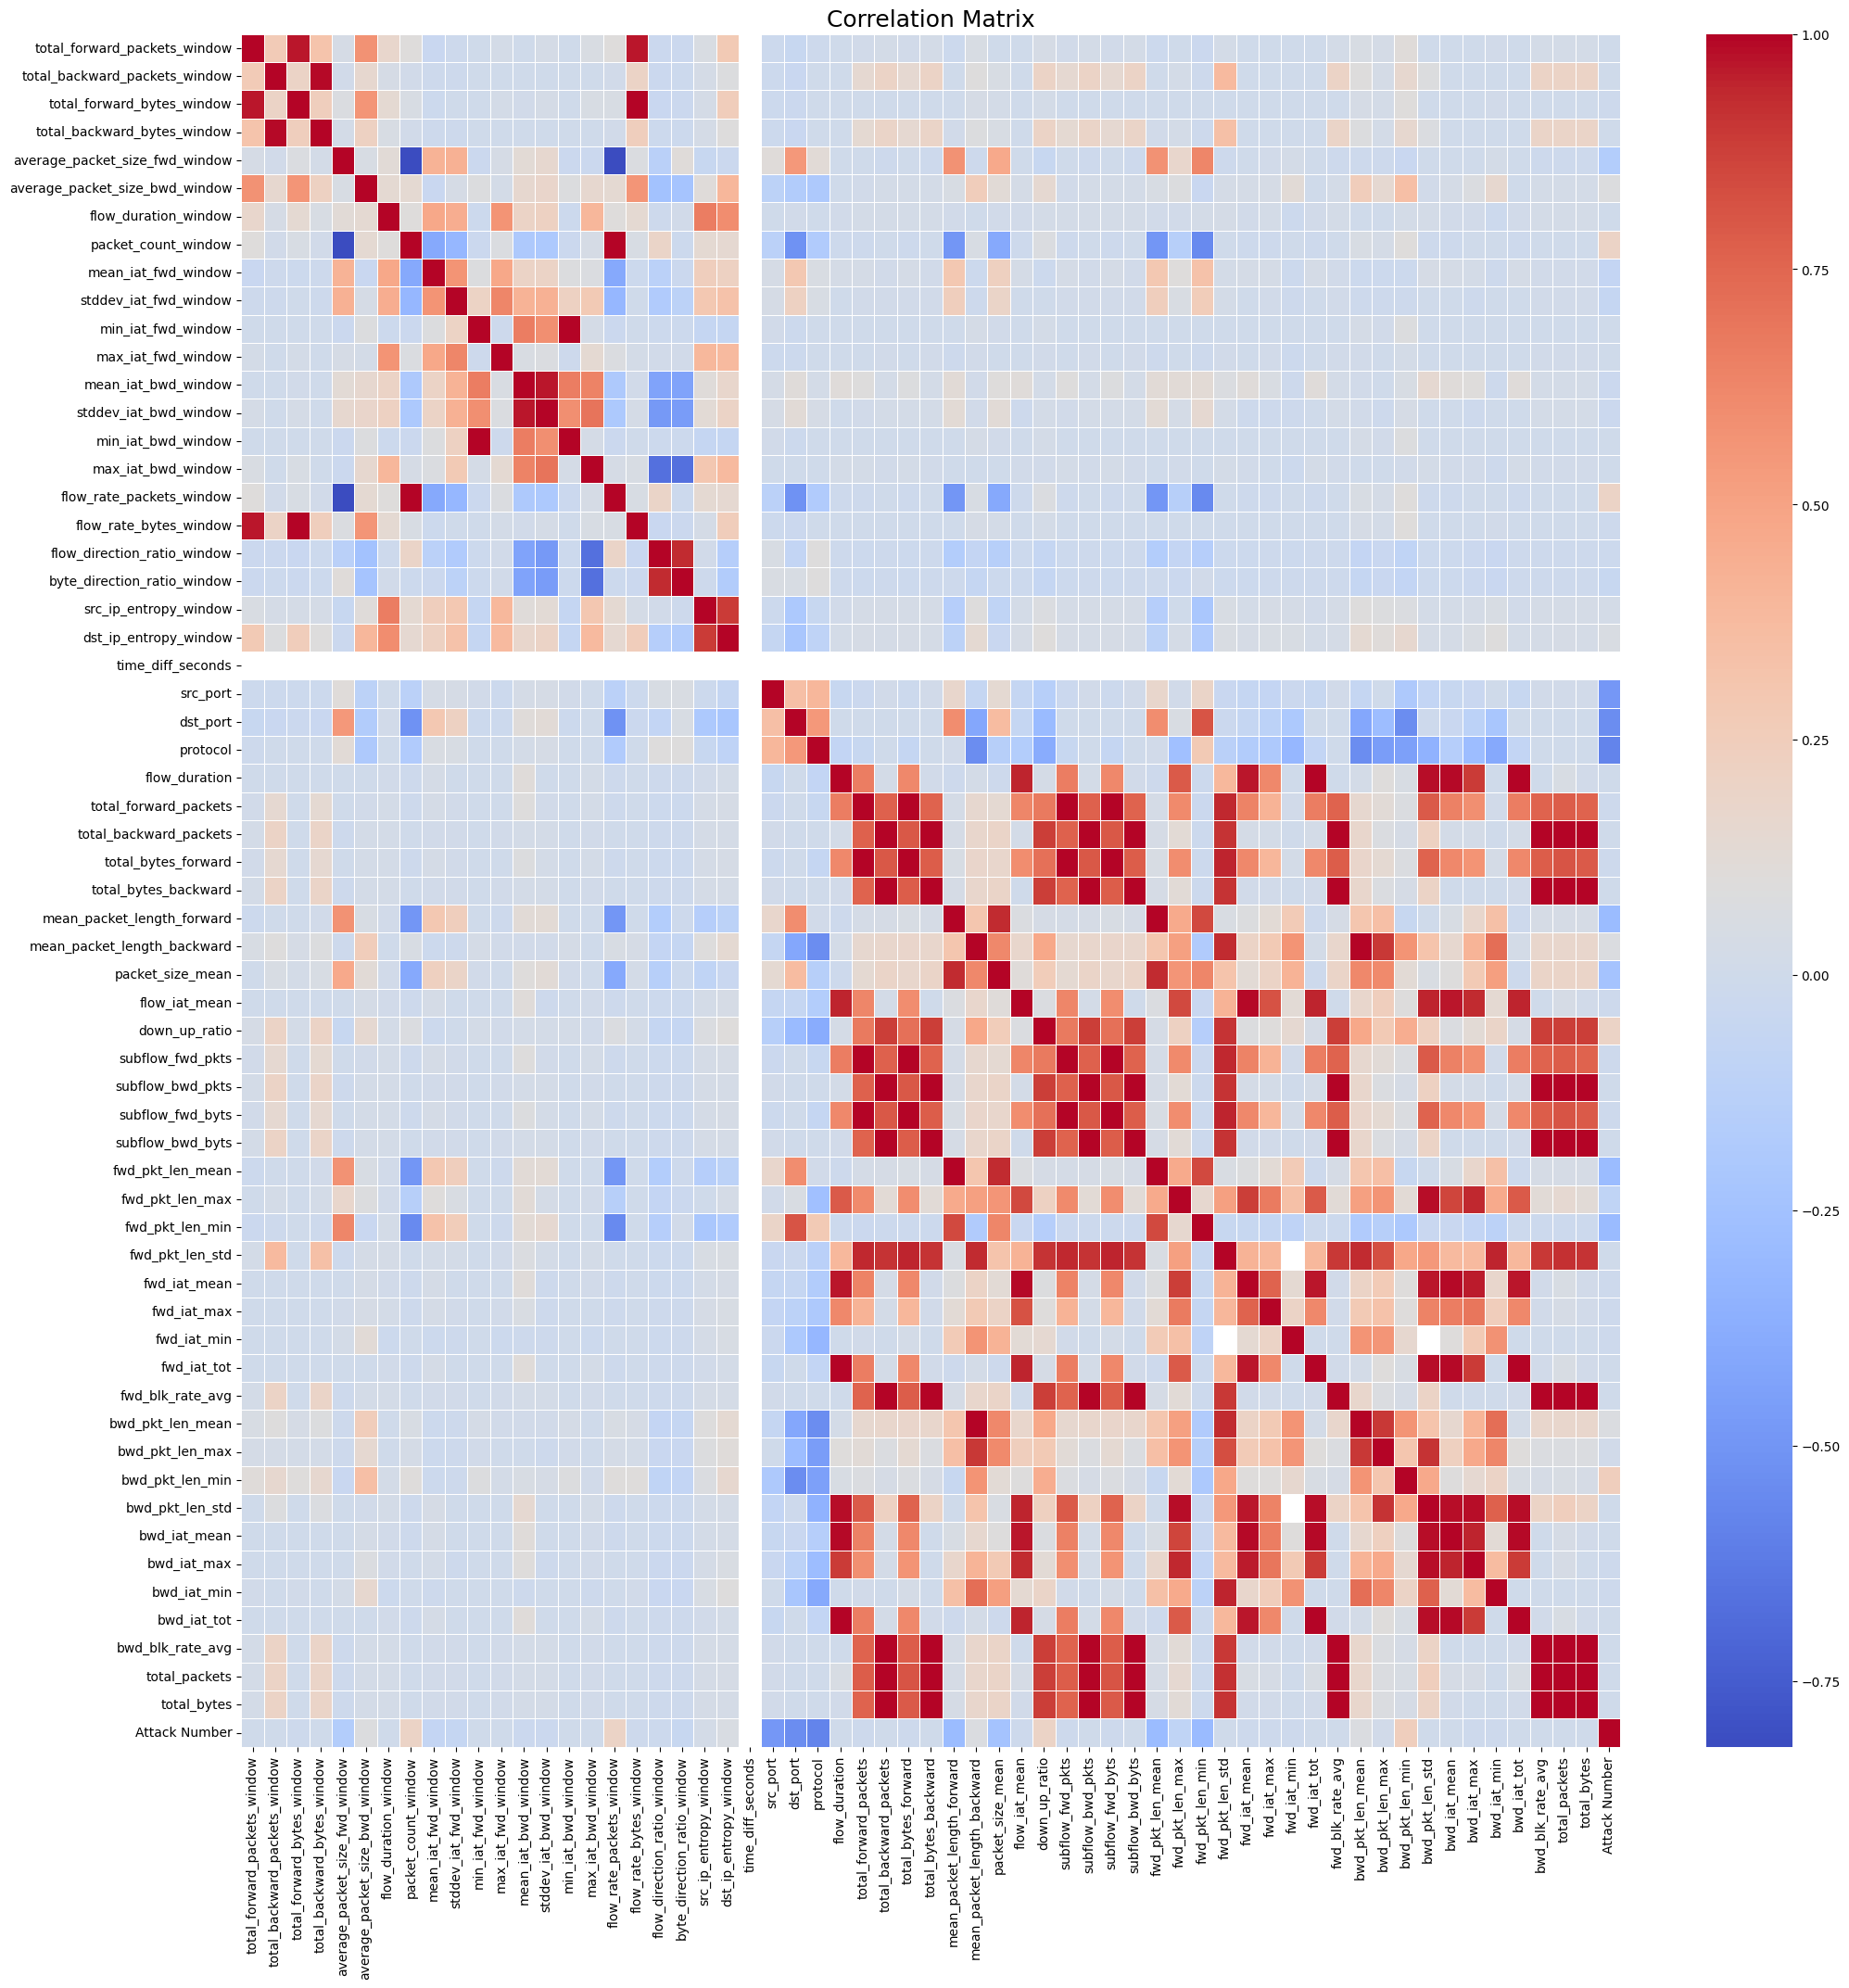

In [ ]:
fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(correlation, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

In [ ]:
# Positive correlation features w.r.t Attacks
positive_correlation = correlation['Attack Number'][(correlation['Attack Number'] > 0) & (correlation['Attack Number'] < 1)].index.tolist()

print("Positive correlation features w.r.t Attacks:\n")
for i, features in enumerate(positive_correlation, start = 1):
    correlation_value = correlation.loc[features, 'Attack Number']
    print('{:<3} {:<24} :{}'.format(f'{i}.', features, correlation_value))

Positive correlation features w.r.t Attacks:

1.  average_packet_size_bwd_window :0.08
2.  packet_count_window      :0.2
3.  flow_rate_packets_window :0.2
4.  src_ip_entropy_window    :0.02
5.  dst_ip_entropy_window    :0.06
6.  mean_packet_length_backward :0.07
7.  down_up_ratio            :0.2
8.  bwd_pkt_len_mean         :0.07
9.  bwd_pkt_len_max          :0.01
10. bwd_pkt_len_min          :0.24


In [ ]:
print(f'No of important features: {len(positive_correlation)}')

No of important features: 10


In [ ]:
# zero standard deviation
std = aggregated_data.std(numeric_only = True)
zero_std_cols = std[std == 0].index.tolist()
zero_std_cols

['time_diff_seconds']

In [ ]:
# unique value
indent = '{:<3} {:<30}: {}'
print('Unique value count on Data: ')
for i, feature in enumerate(list(aggregated_data.columns)[:-1], start = 1):
    print(indent.format(f'{i}.', feature, aggregated_data[feature].nunique()))

Unique value count on Data: 
1.  start_time                    : 23986
2.  end_time_x                    : 23986
3.  total_forward_packets_window  : 190
4.  total_backward_packets_window : 101
5.  total_forward_bytes_window    : 3690
6.  total_backward_bytes_window   : 343
7.  average_packet_size_fwd_window: 3674
8.  average_packet_size_bwd_window: 802
9.  flow_duration_window          : 4597
10. packet_count_window           : 123
11. mean_iat_fwd_window           : 4560
12. stddev_iat_fwd_window         : 4553
13. min_iat_fwd_window            : 3
14. max_iat_fwd_window            : 4091
15. mean_iat_bwd_window           : 1977
16. stddev_iat_bwd_window         : 1980
17. min_iat_bwd_window            : 3
18. max_iat_bwd_window            : 1628
19. flow_rate_packets_window      : 123
20. flow_rate_bytes_window        : 3690
21. flow_direction_ratio_window   : 761
22. byte_direction_ratio_window   : 4068
23. src_ip_entropy_window         : 1237
24. dst_ip_entropy_window         : 107

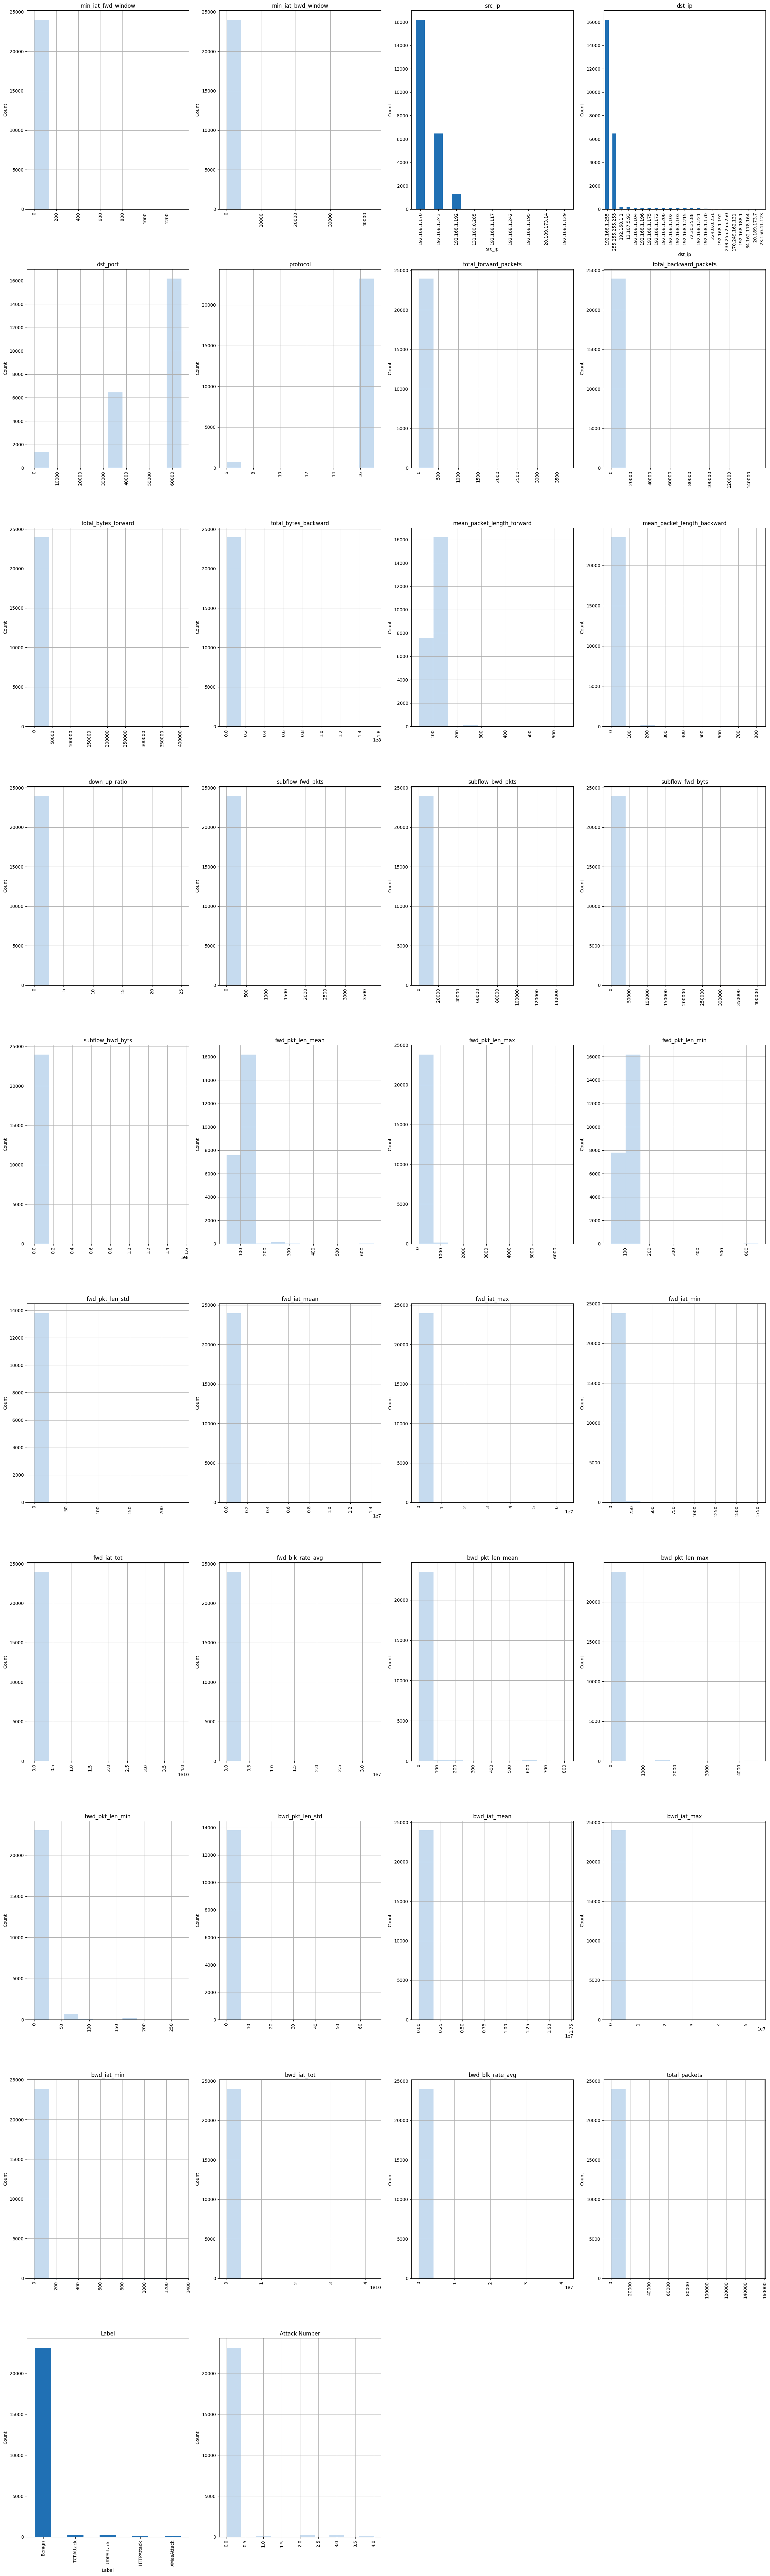

In [ ]:
unique_values = aggregated_data.nunique()
selected_cols = aggregated_data[[col for col in aggregated_data if 1 < unique_values[col] < 50]]
rows, cols = selected_cols.shape
col_names = list(selected_cols)
num_of_rows = (cols + 3) // 4

color_palette = sns.color_palette('Blues', n_colors = 3)
plt.figure(figsize = (6 * 4, 8 * num_of_rows))

for i in range(cols):
    plt.subplot(num_of_rows, 4, i + 1)
    col_data = selected_cols.iloc[:, i]
    if col_data.dtype.name == 'object':
        col_data.value_counts().plot(kind = 'bar', color = color_palette[2])
    else:
        col_data.hist(color = color_palette[0])

    plt.ylabel('Count')
    plt.xticks(rotation = 90)
    plt.title(col_names[i])

plt.tight_layout()
plt.show()

In [ ]:
cols = aggregated_data.select_dtypes(include=[np.number]).columns
high_corr_pairs = []
corr_th = 0.85

# correlations numeric columns
for i in range(len(cols)):
  for j in range(i + 1, len(cols)):
    val = aggregated_data[cols[i]].corr(aggregated_data[cols[j]])
    # If the correlation coefficient is NaN or below the threshold, skip to the next pair
    if np.isnan(val) or val < corr_th:
      continue
    high_corr_pairs.append((val, cols[i], cols[j]))

# number of correlation pairs
size, cols = len(high_corr_pairs), 4
rows, rem =  size // cols, size % cols
if rem:
  rows += 1

fig, axs = plt.subplots(rows, cols, figsize = (24, int(size * 1.7)))
for i in range(rows):
    for j in range(cols):
      try:
        val, x, y = high_corr_pairs[i * cols + j]
        if val > 0.99:
          axs[i, j].scatter(aggregated_data[x], aggregated_data[y], color = 'green', alpha = 0.1)
        else:
          axs[i, j].scatter(aggregated_data[x], aggregated_data[y], color = 'blue', alpha = 0.1)
        axs[i, j].set_xlabel(x)
        axs[i, j].set_ylabel(y)
        axs[i, j].set_title(f'{x} vs\n{y} ({val:.2f})')
      except IndexError:
        fig.delaxes(axs[i, j])

fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
aggregated_data.drop('Attack Number', axis = 1, inplace = True)

In [ ]:
# outliers
numeric_data = aggregated_data.select_dtypes(include = ['float', 'int'])
q1 = numeric_data.quantile(0.25)
q3 = numeric_data.quantile(0.75)
iqr = q3 - q1
outlier = (numeric_data < (q1 - 1.5 * iqr)) | (numeric_data > (q3 + 1.5 * iqr))
outlier_count = outlier.sum()
outlier_percentage = round(outlier.mean() * 100, 2)
outlier_stats = pd.concat([outlier_count, outlier_percentage], axis = 1)
outlier_stats.columns = ['Outlier Count', 'Outlier Percentage']
print(outlier_stats)

                                Outlier Count  Outlier Percentage
total_forward_packets_window              461                1.92
total_backward_packets_window            1131                4.72
total_forward_bytes_window                236                0.98
total_backward_bytes_window              1756                7.32
average_packet_size_fwd_window             10                0.04
average_packet_size_bwd_window           1901                7.93
flow_duration_window                      196                0.82
packet_count_window                       666                2.78
mean_iat_fwd_window                       285                1.19
stddev_iat_fwd_window                     720                3.00
min_iat_fwd_window                         10                0.04
max_iat_fwd_window                        460                1.92
mean_iat_bwd_window                       175                0.73
stddev_iat_bwd_window                      80                0.33
min_iat_bw

In [ ]:
# outliers w.r.t attack type
outlier_counts = {}
for i in numeric_data:
    for label in aggregated_data['Label'].unique():
        attack_data = aggregated_data[i][aggregated_data['Label'] == label]
        q1, q3 = np.percentile(attack_data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        num_outliers = ((attack_data < lower_bound) | (attack_data > upper_bound)).sum()
        outlier_percent = num_outliers / len(attack_data) * 100
        outlier_counts[(i, label)] = (num_outliers, outlier_percent)

for i in numeric_data:
  print(f'Feature: {i}')
  for label in aggregated_data['Label'].unique():
    num_outliers, outlier_percent = outlier_counts[(i, label)]
    print(f'- {label}: {num_outliers} ({outlier_percent:.2f}%)')
  print()

Feature: total_forward_packets_window
- XMasAttack: 6 (4.62%)
- Benign: 434 (1.87%)
- TCPAttack: 0 (0.00%)
- UDPAttack: 5 (1.89%)
- HTTPAttack: 0 (0.00%)

Feature: total_backward_packets_window
- XMasAttack: 25 (19.23%)
- Benign: 867 (3.74%)
- TCPAttack: 0 (0.00%)
- UDPAttack: 12 (4.53%)
- HTTPAttack: 0 (0.00%)

Feature: total_forward_bytes_window
- XMasAttack: 3 (2.31%)
- Benign: 222 (0.96%)
- TCPAttack: 4 (1.48%)
- UDPAttack: 1 (0.38%)
- HTTPAttack: 0 (0.00%)

Feature: total_backward_bytes_window
- XMasAttack: 12 (9.23%)
- Benign: 1482 (6.40%)
- TCPAttack: 4 (1.48%)
- UDPAttack: 38 (14.34%)
- HTTPAttack: 26 (15.76%)

Feature: average_packet_size_fwd_window
- XMasAttack: 0 (0.00%)
- Benign: 10 (0.04%)
- TCPAttack: 4 (1.48%)
- UDPAttack: 0 (0.00%)
- HTTPAttack: 4 (2.42%)

Feature: average_packet_size_bwd_window
- XMasAttack: 0 (0.00%)
- Benign: 1549 (6.69%)
- TCPAttack: 0 (0.00%)
- UDPAttack: 45 (16.98%)
- HTTPAttack: 0 (0.00%)

Feature: flow_duration_window
- XMasAttack: 1 (0.77%)
- B

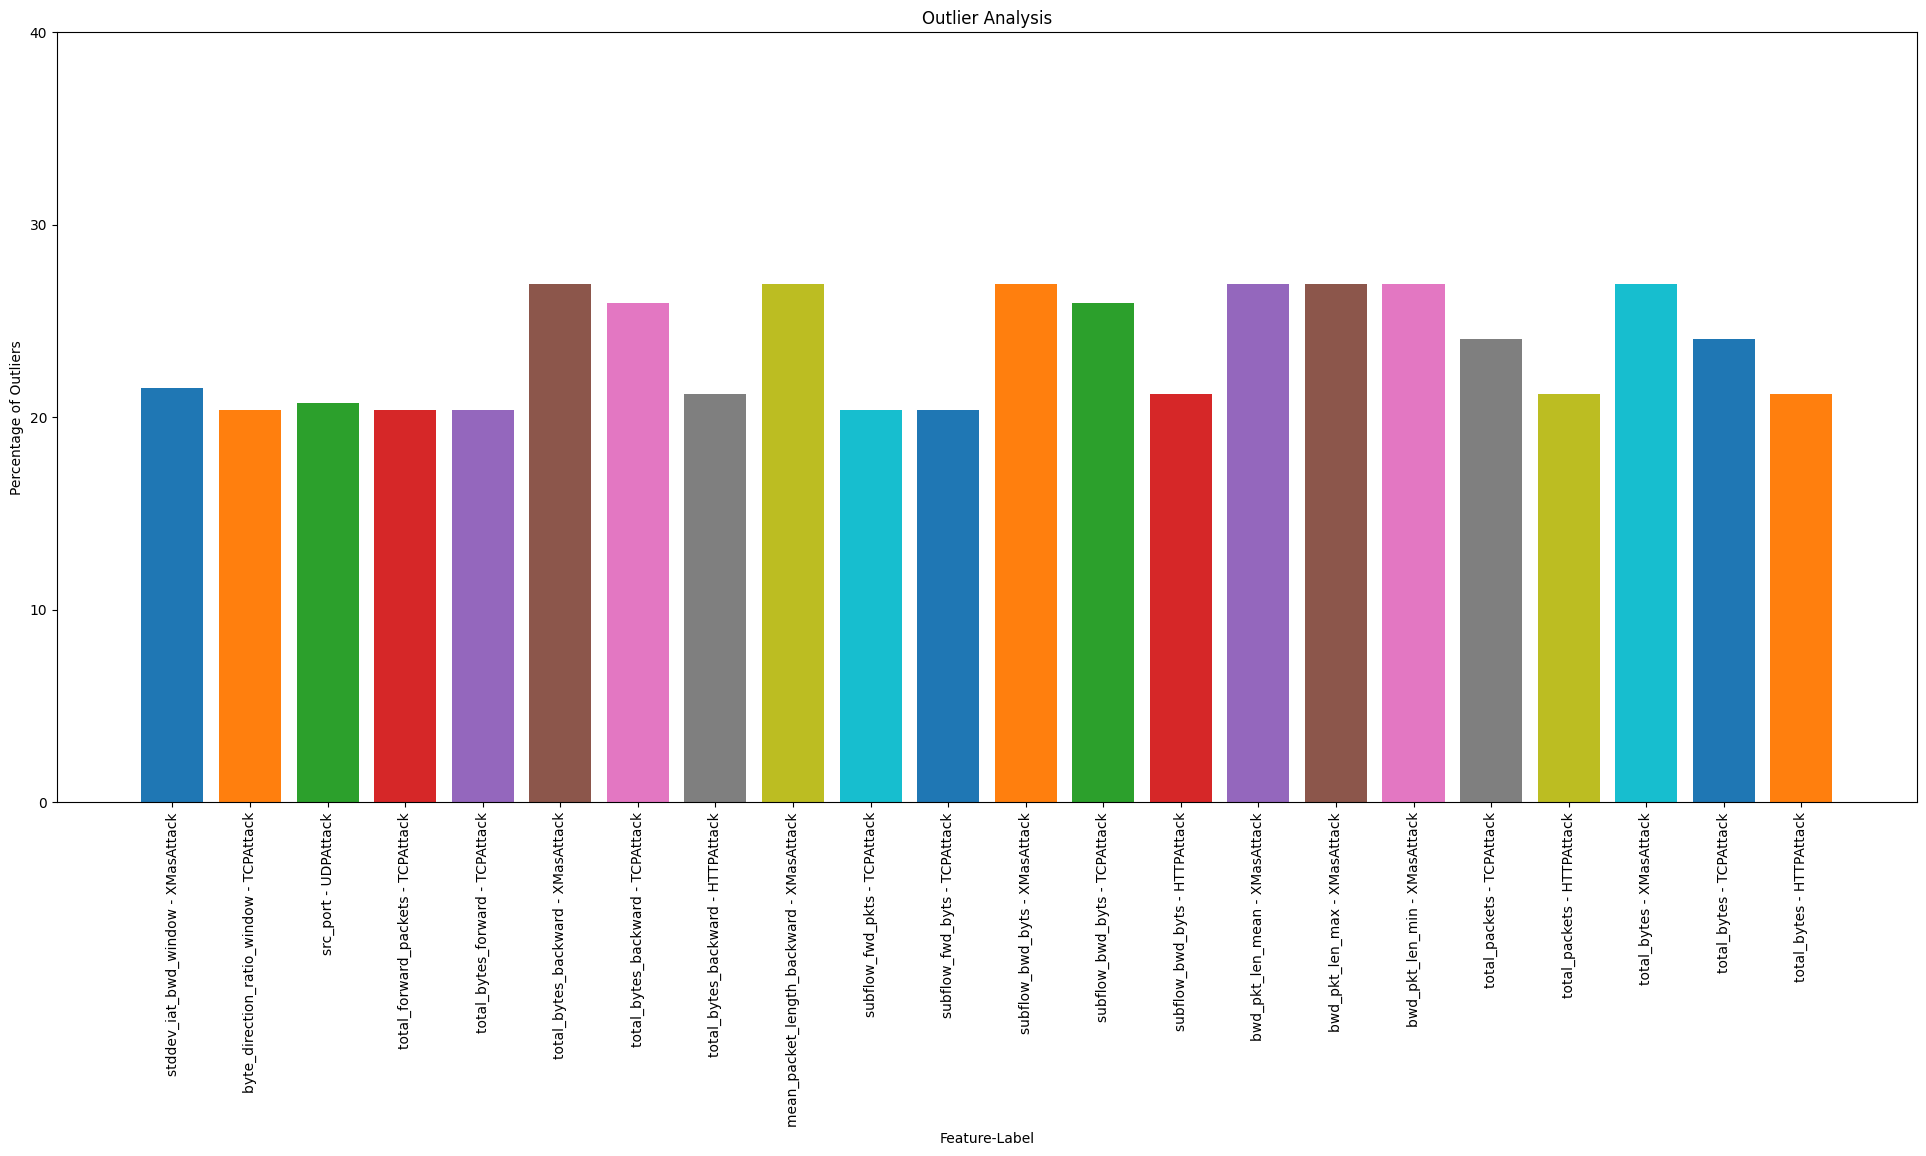

In [ ]:
# % of outliers > 20%
fig, ax = plt.subplots(figsize = (24, 10))
for i in numeric_data:
    for label in aggregated_data['Label'].unique():
        num_outliers, outlier_percent = outlier_counts[(i, label)]
        if outlier_percent > 20:
            ax.bar(f'{i} - {label}', outlier_percent)

ax.set_xlabel('Feature-Label')
ax.set_ylabel('Percentage of Outliers')
ax.set_title('Outlier Analysis')
ax.set_yticks(np.arange(0, 41, 10))
plt.xticks(rotation = 90)
plt.show()

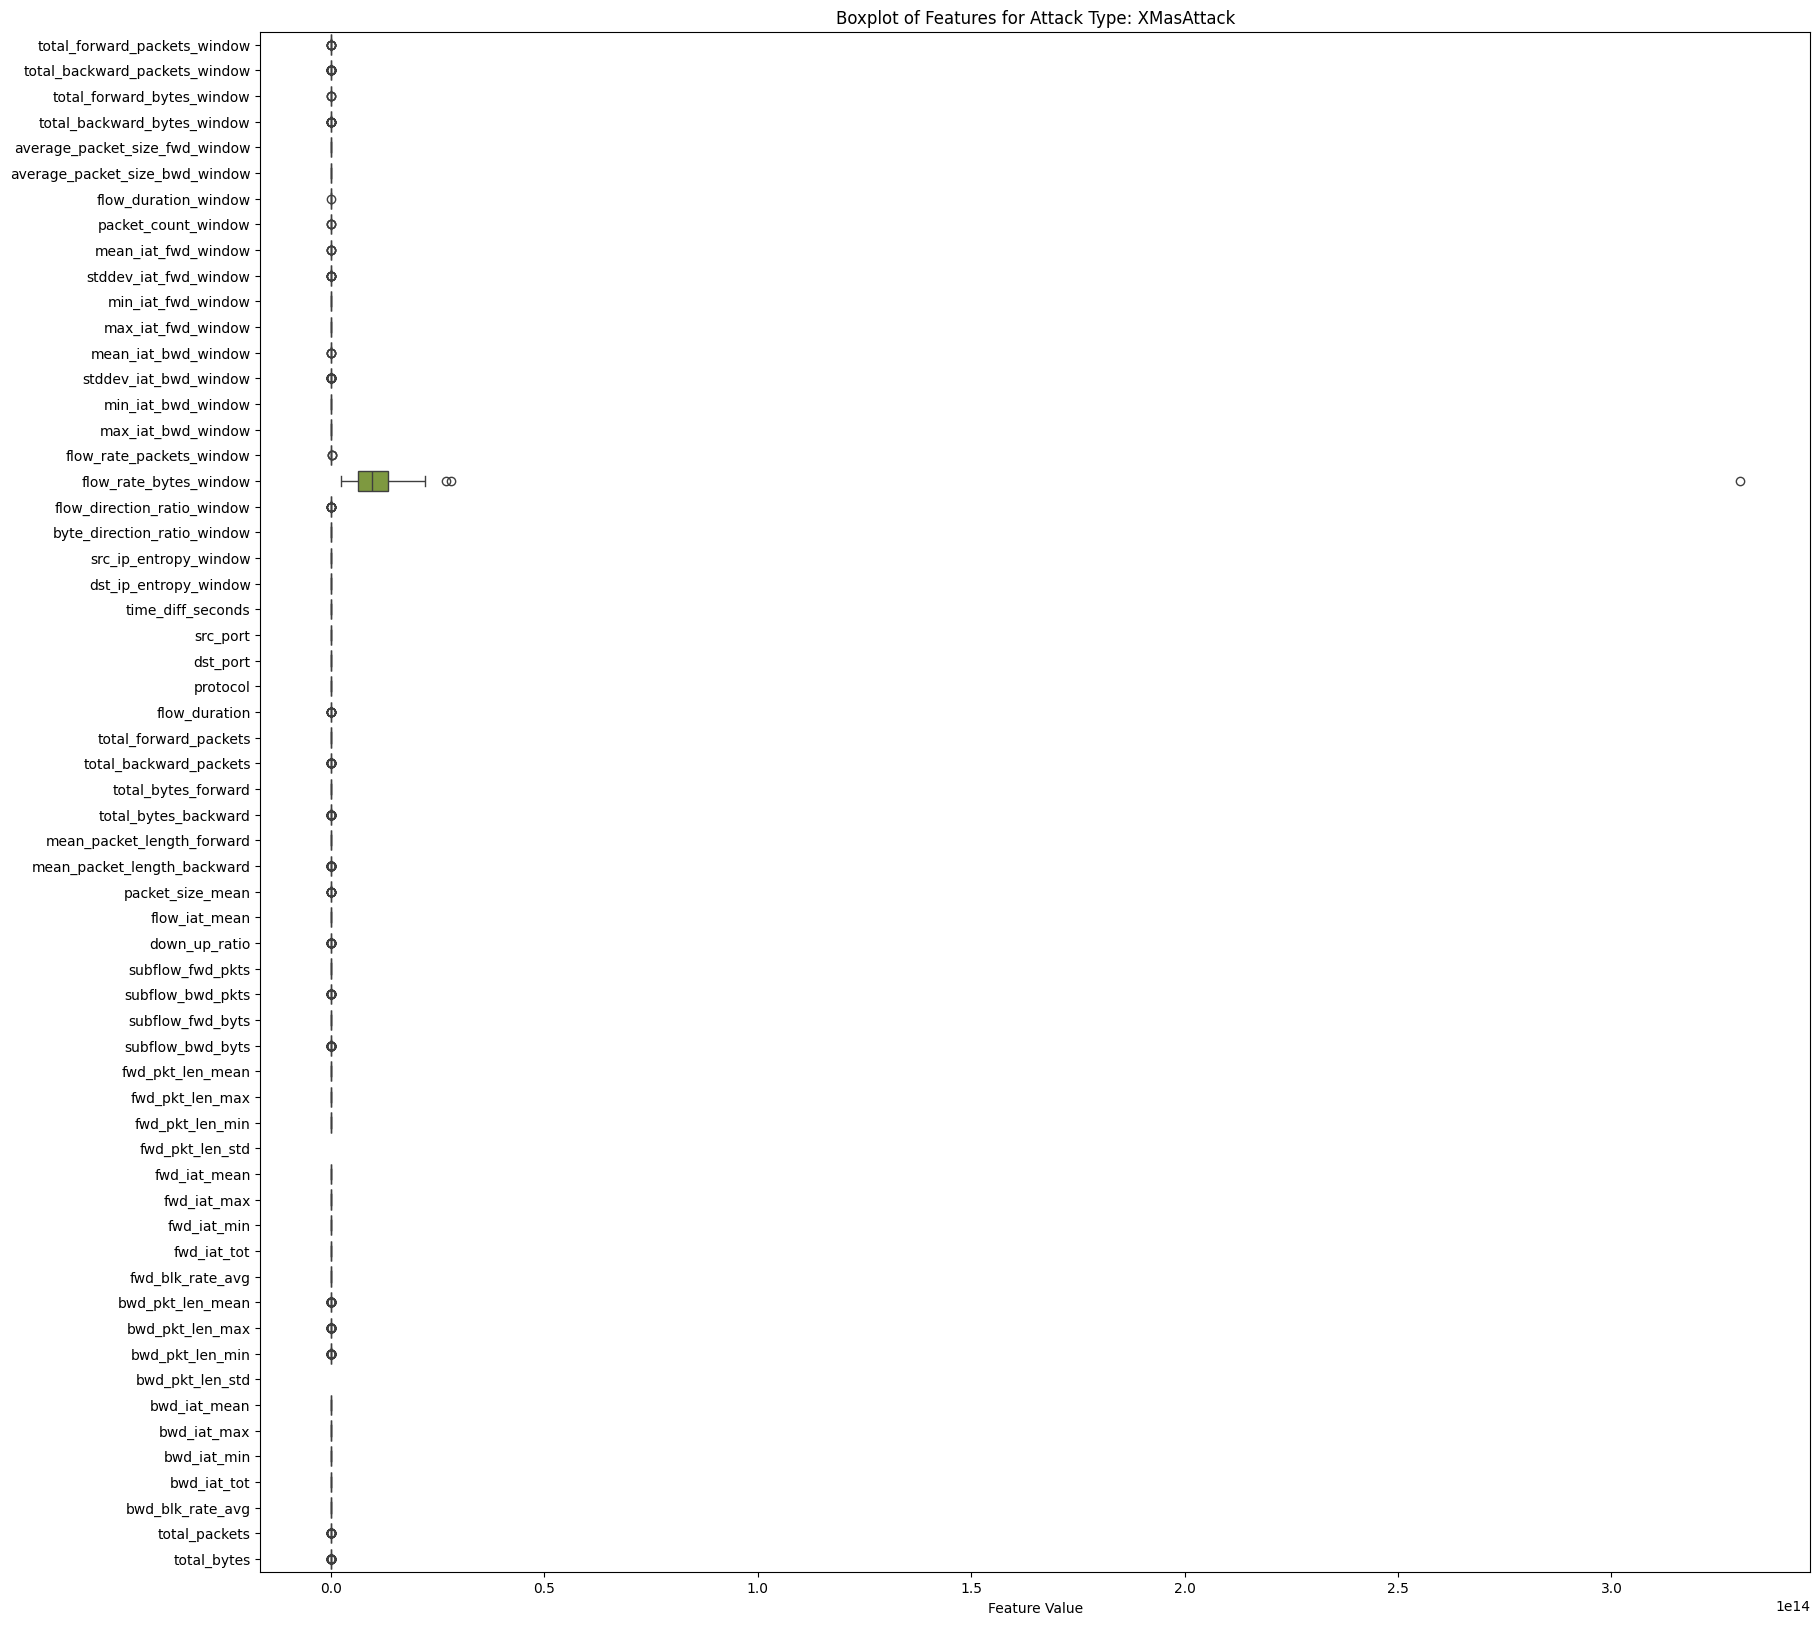

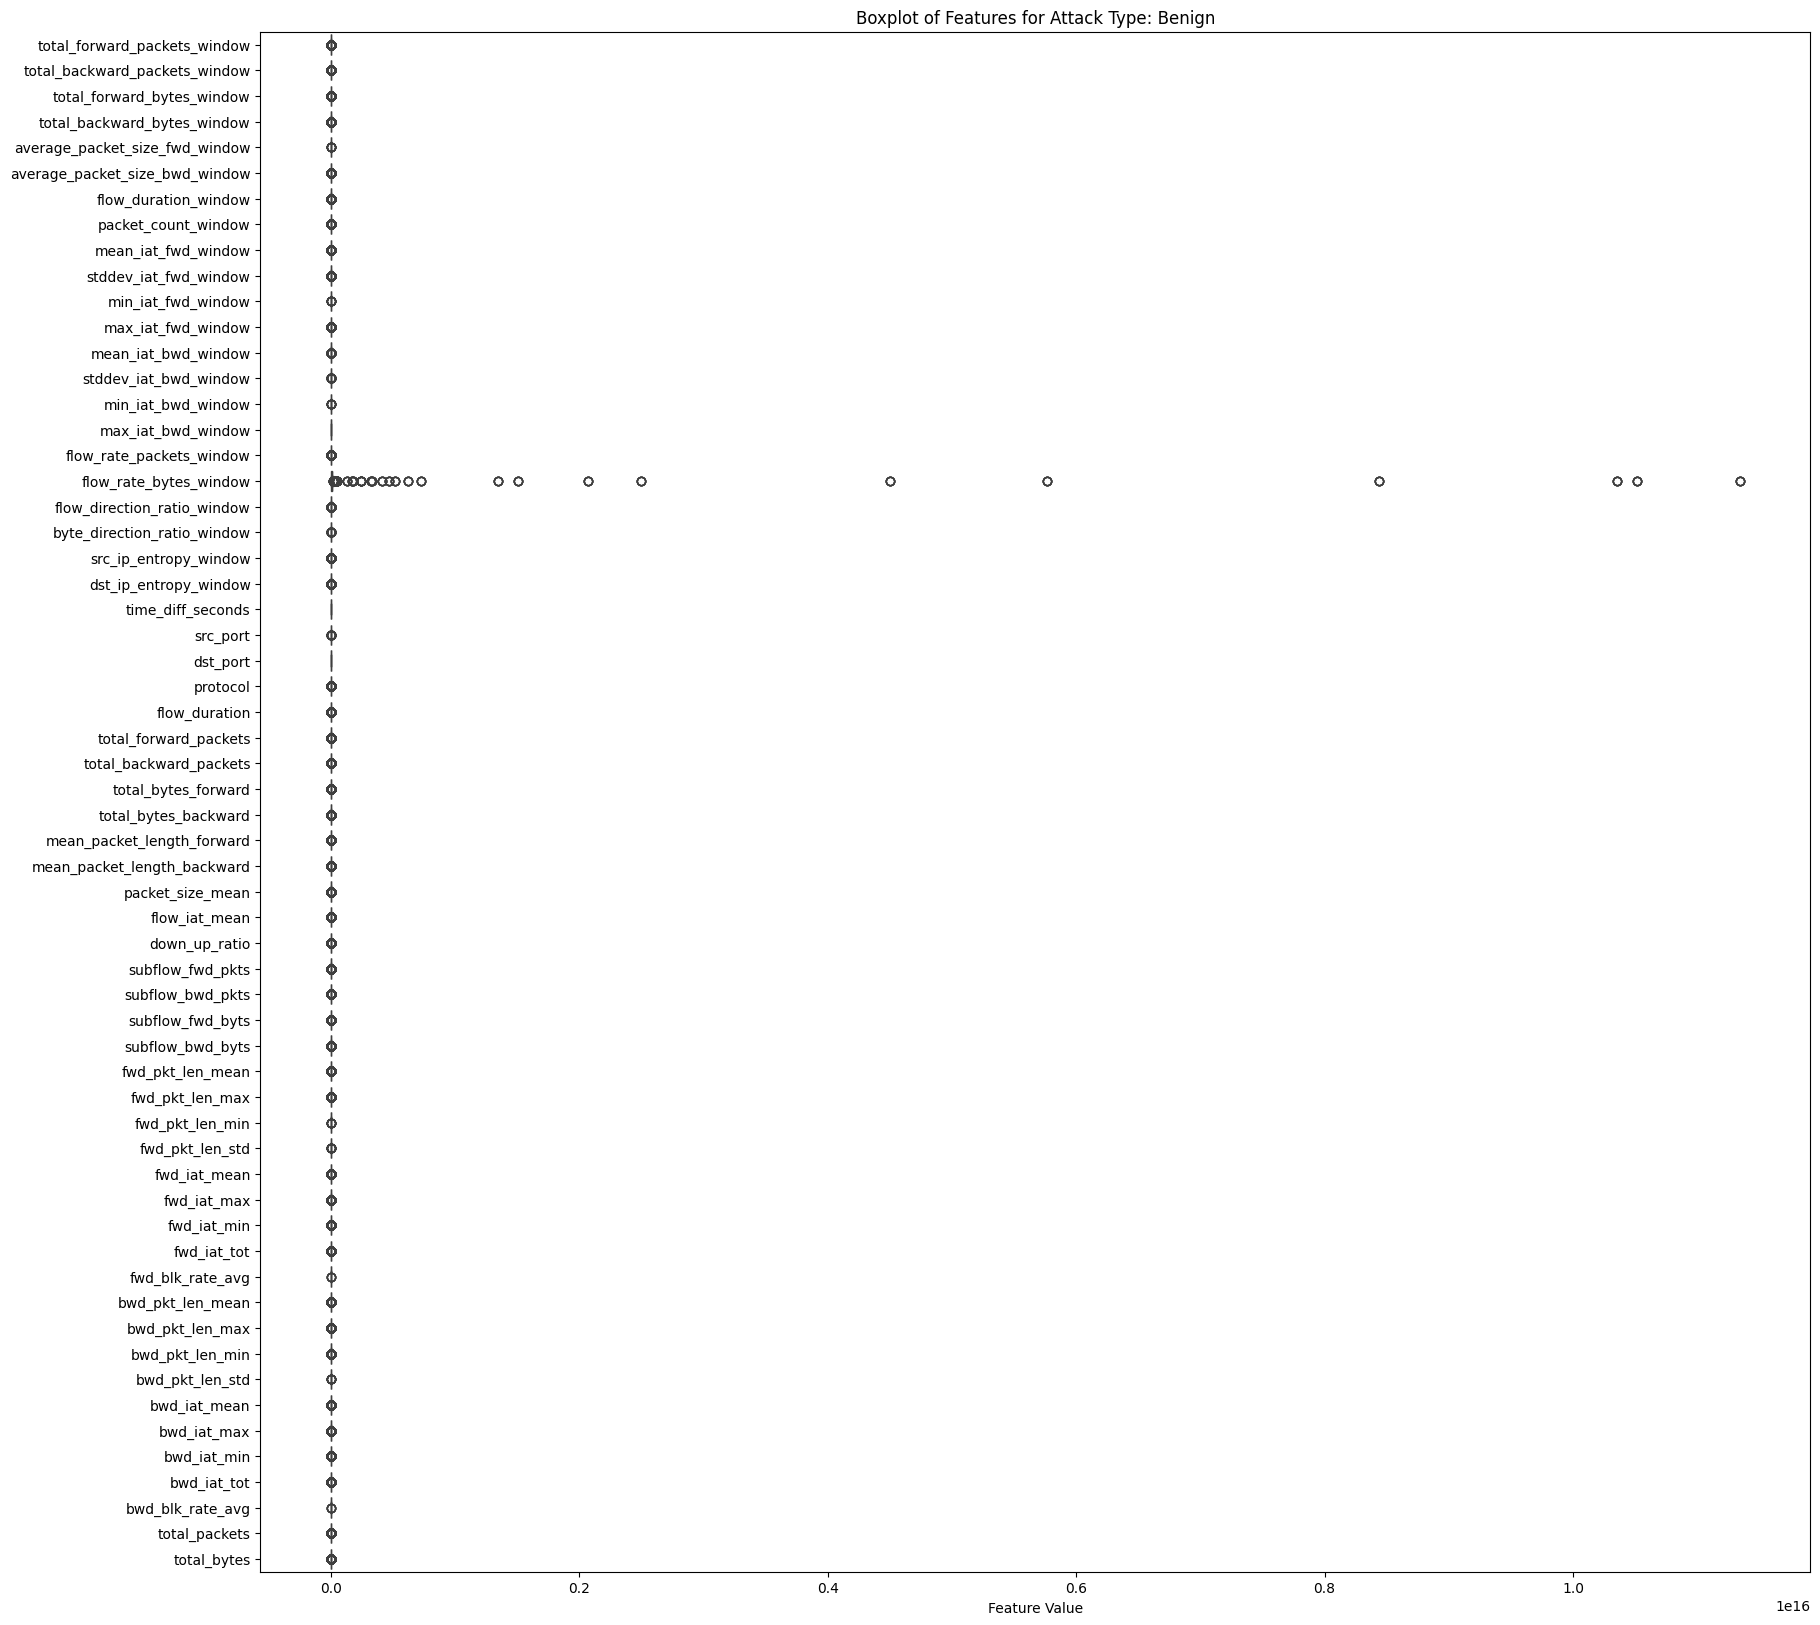

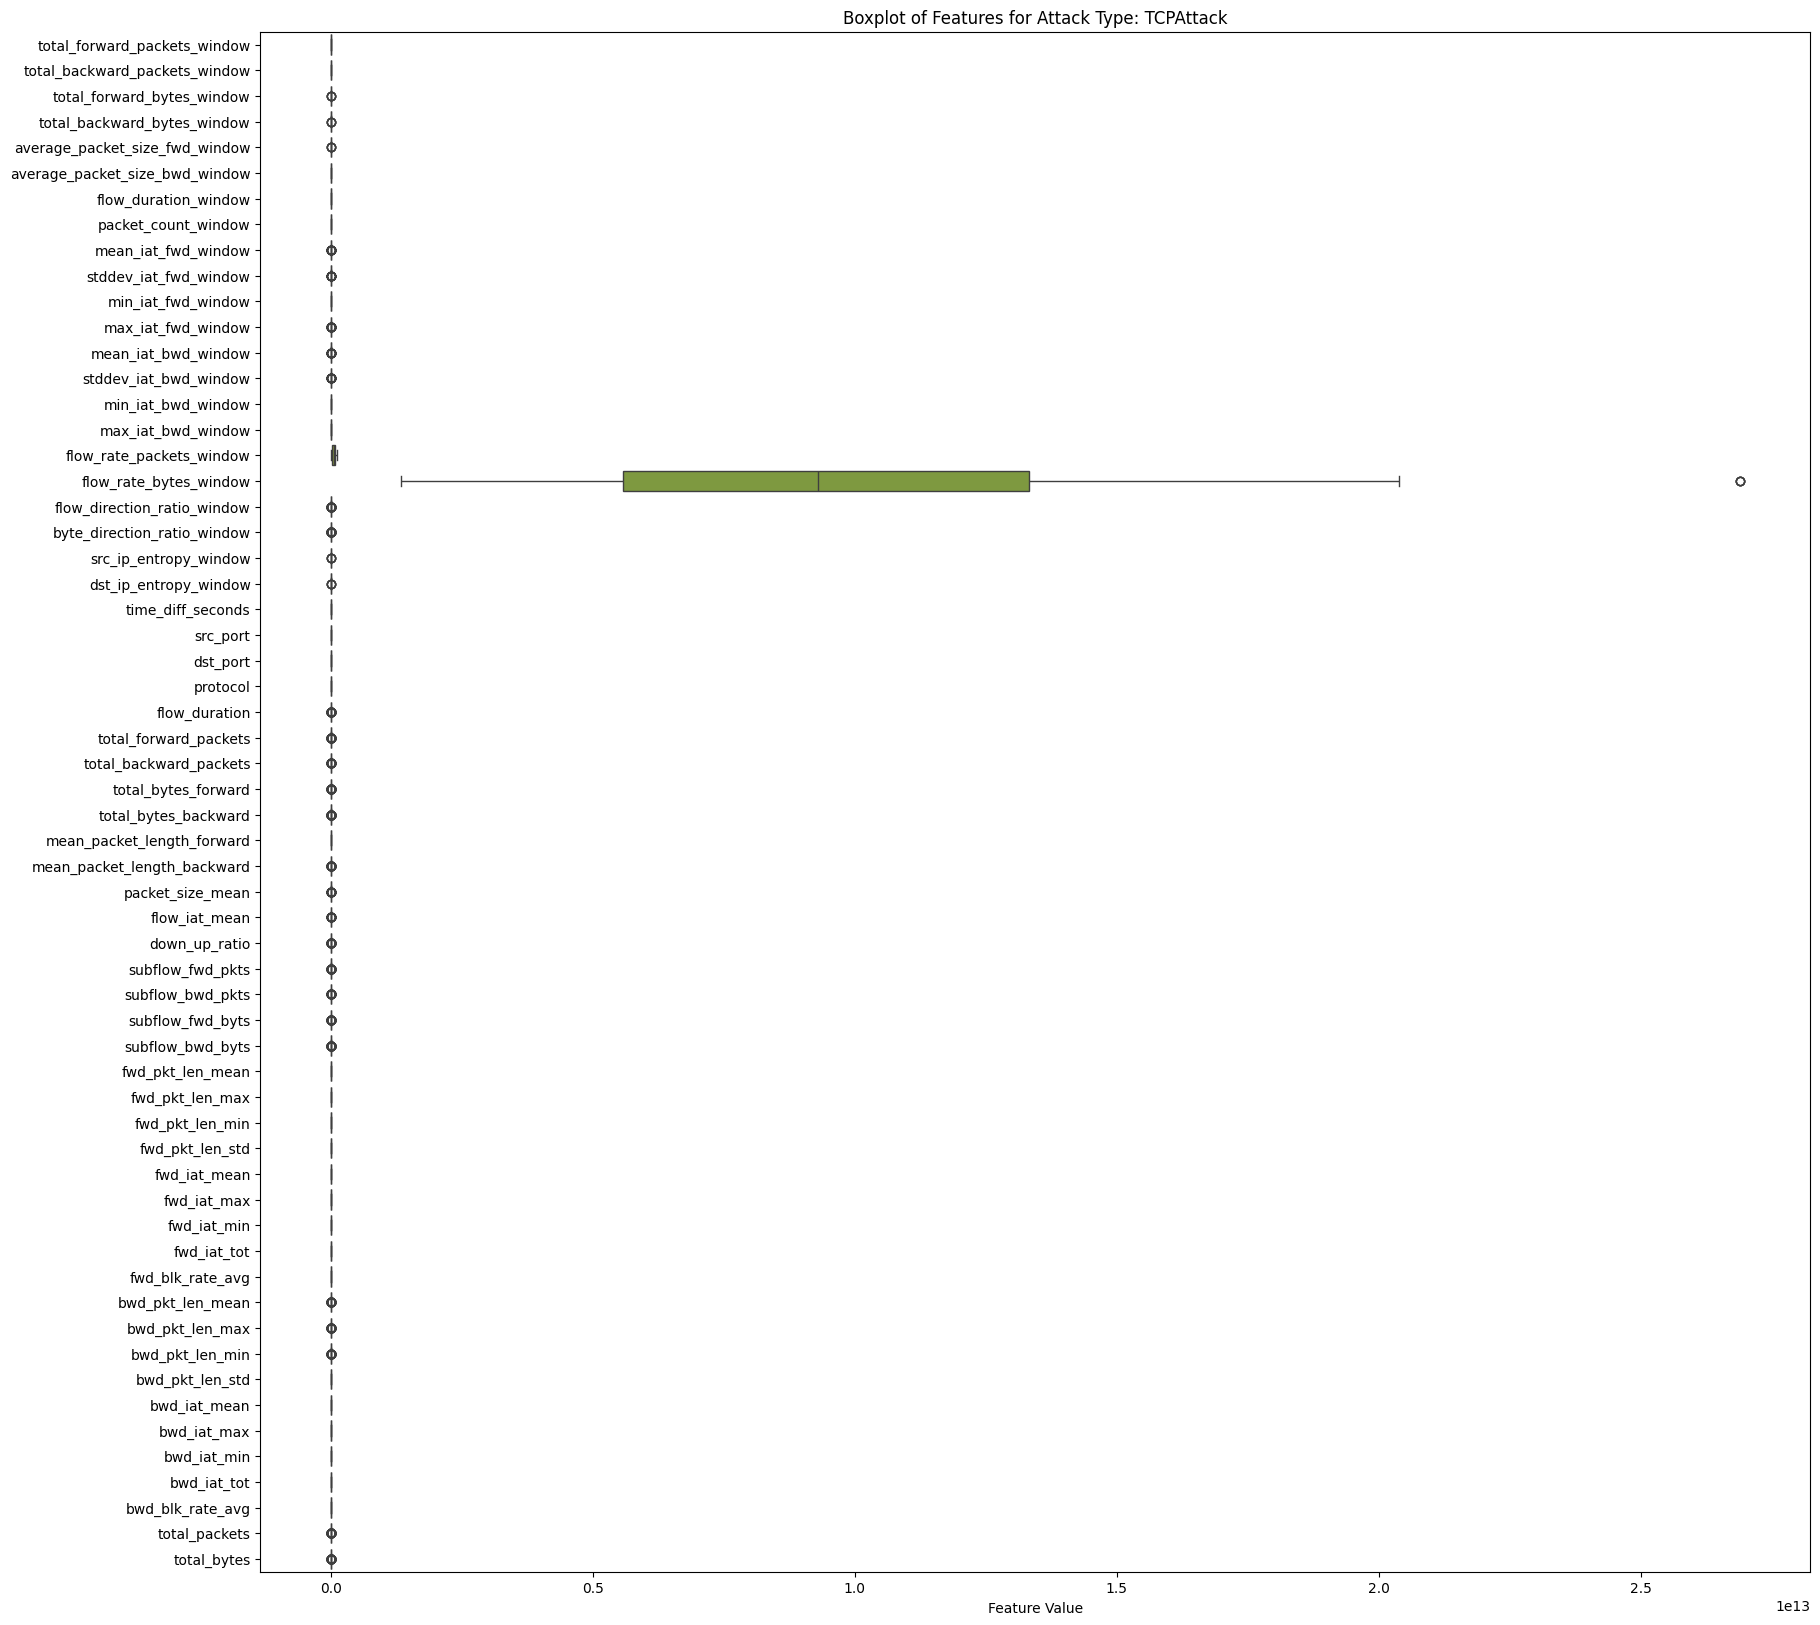

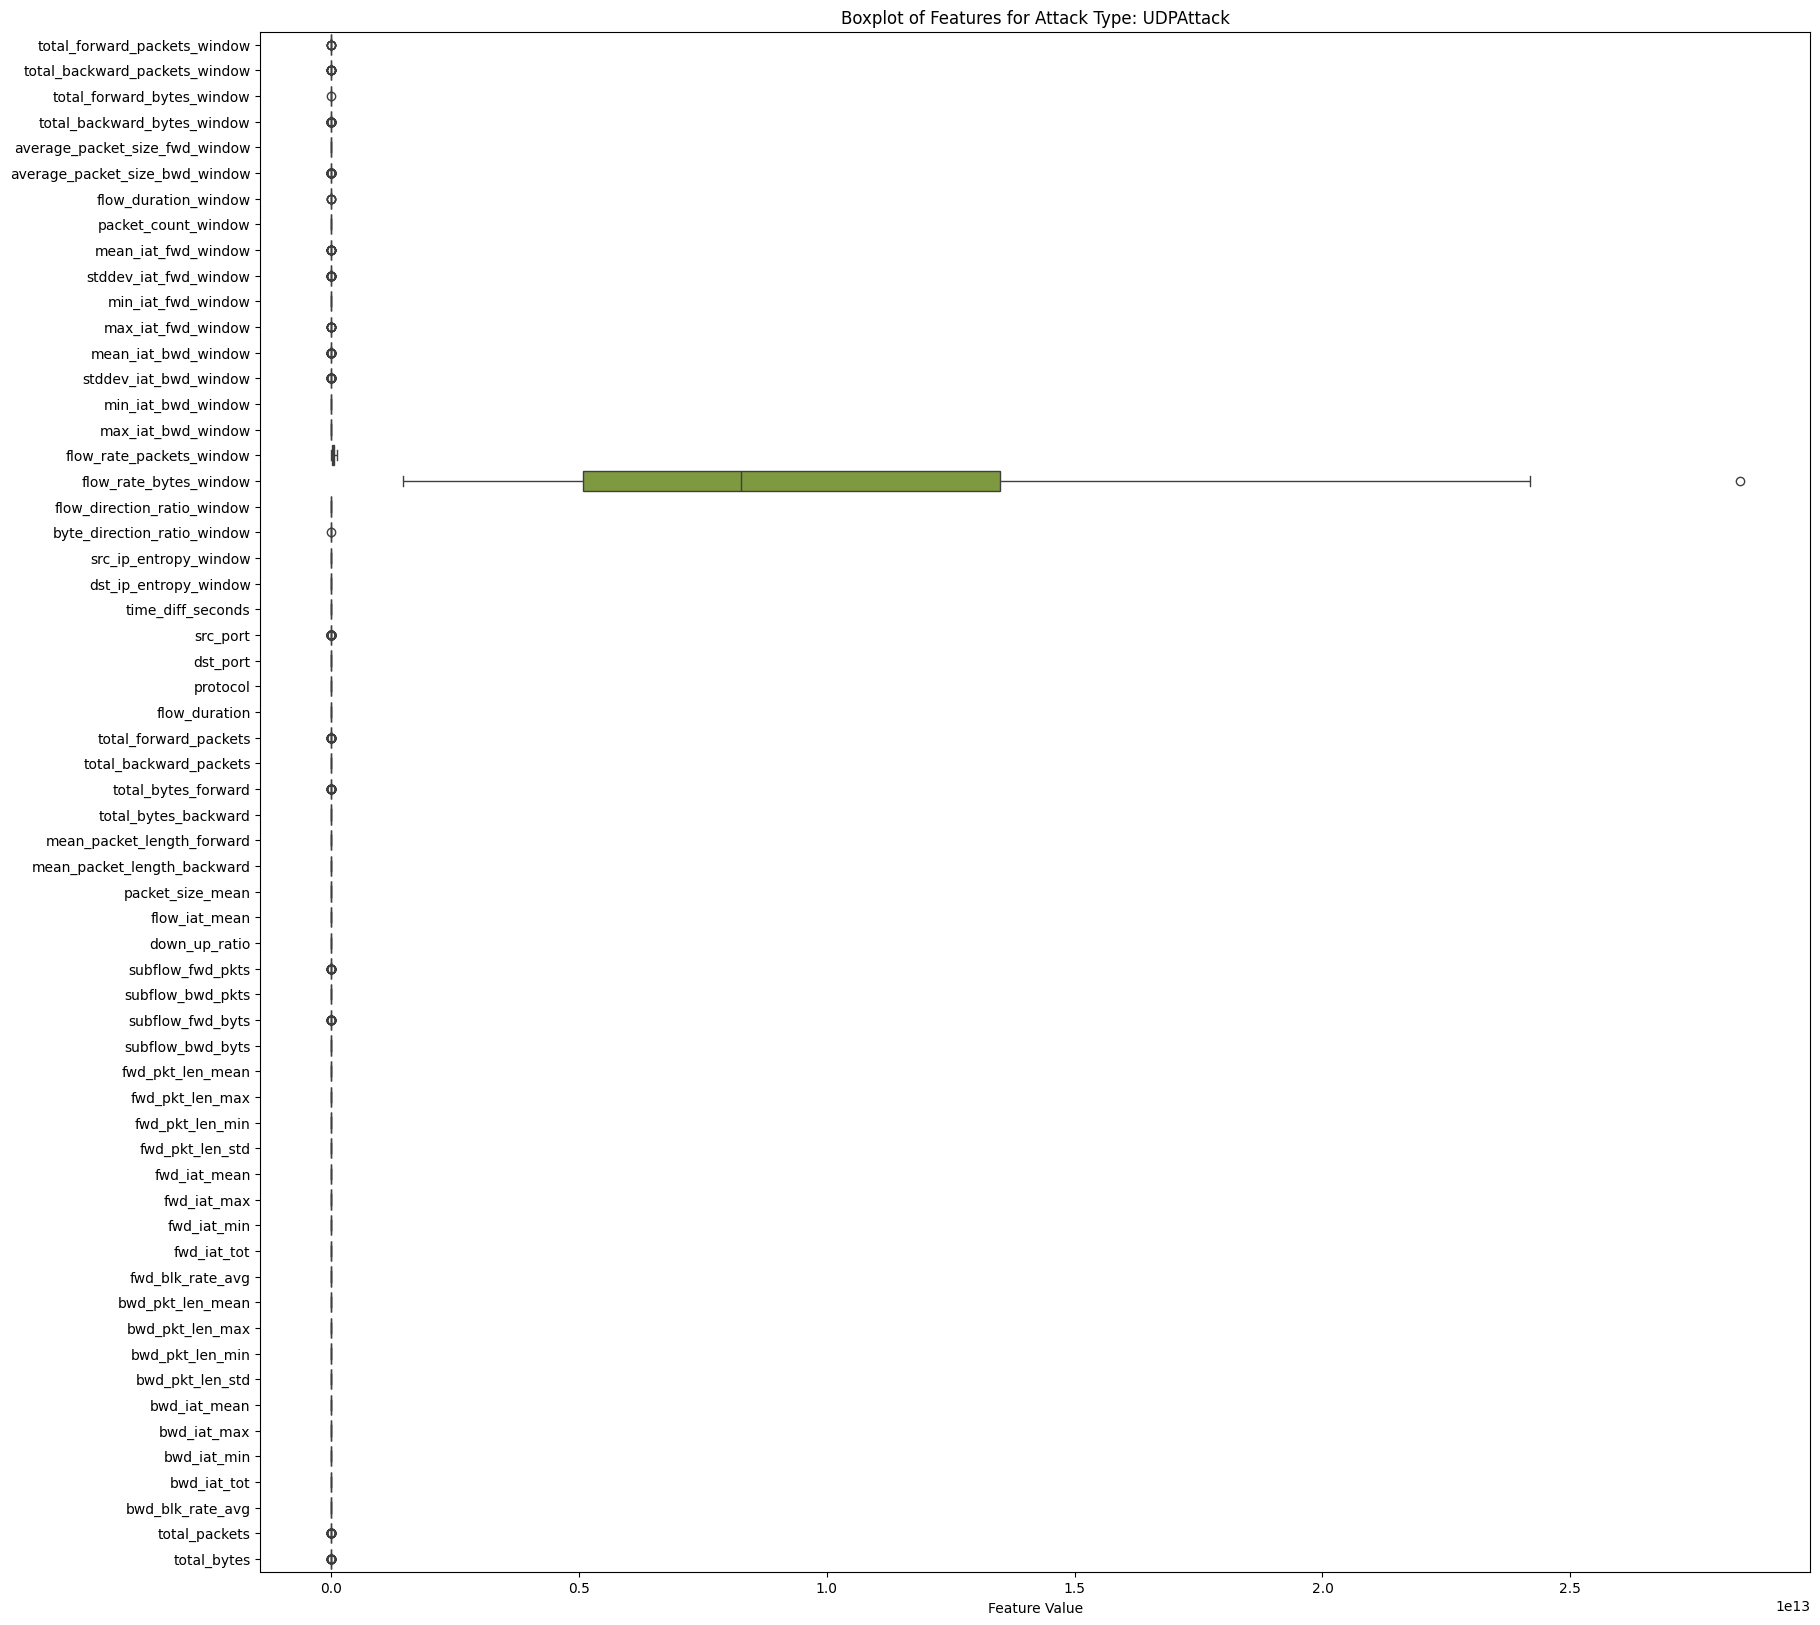

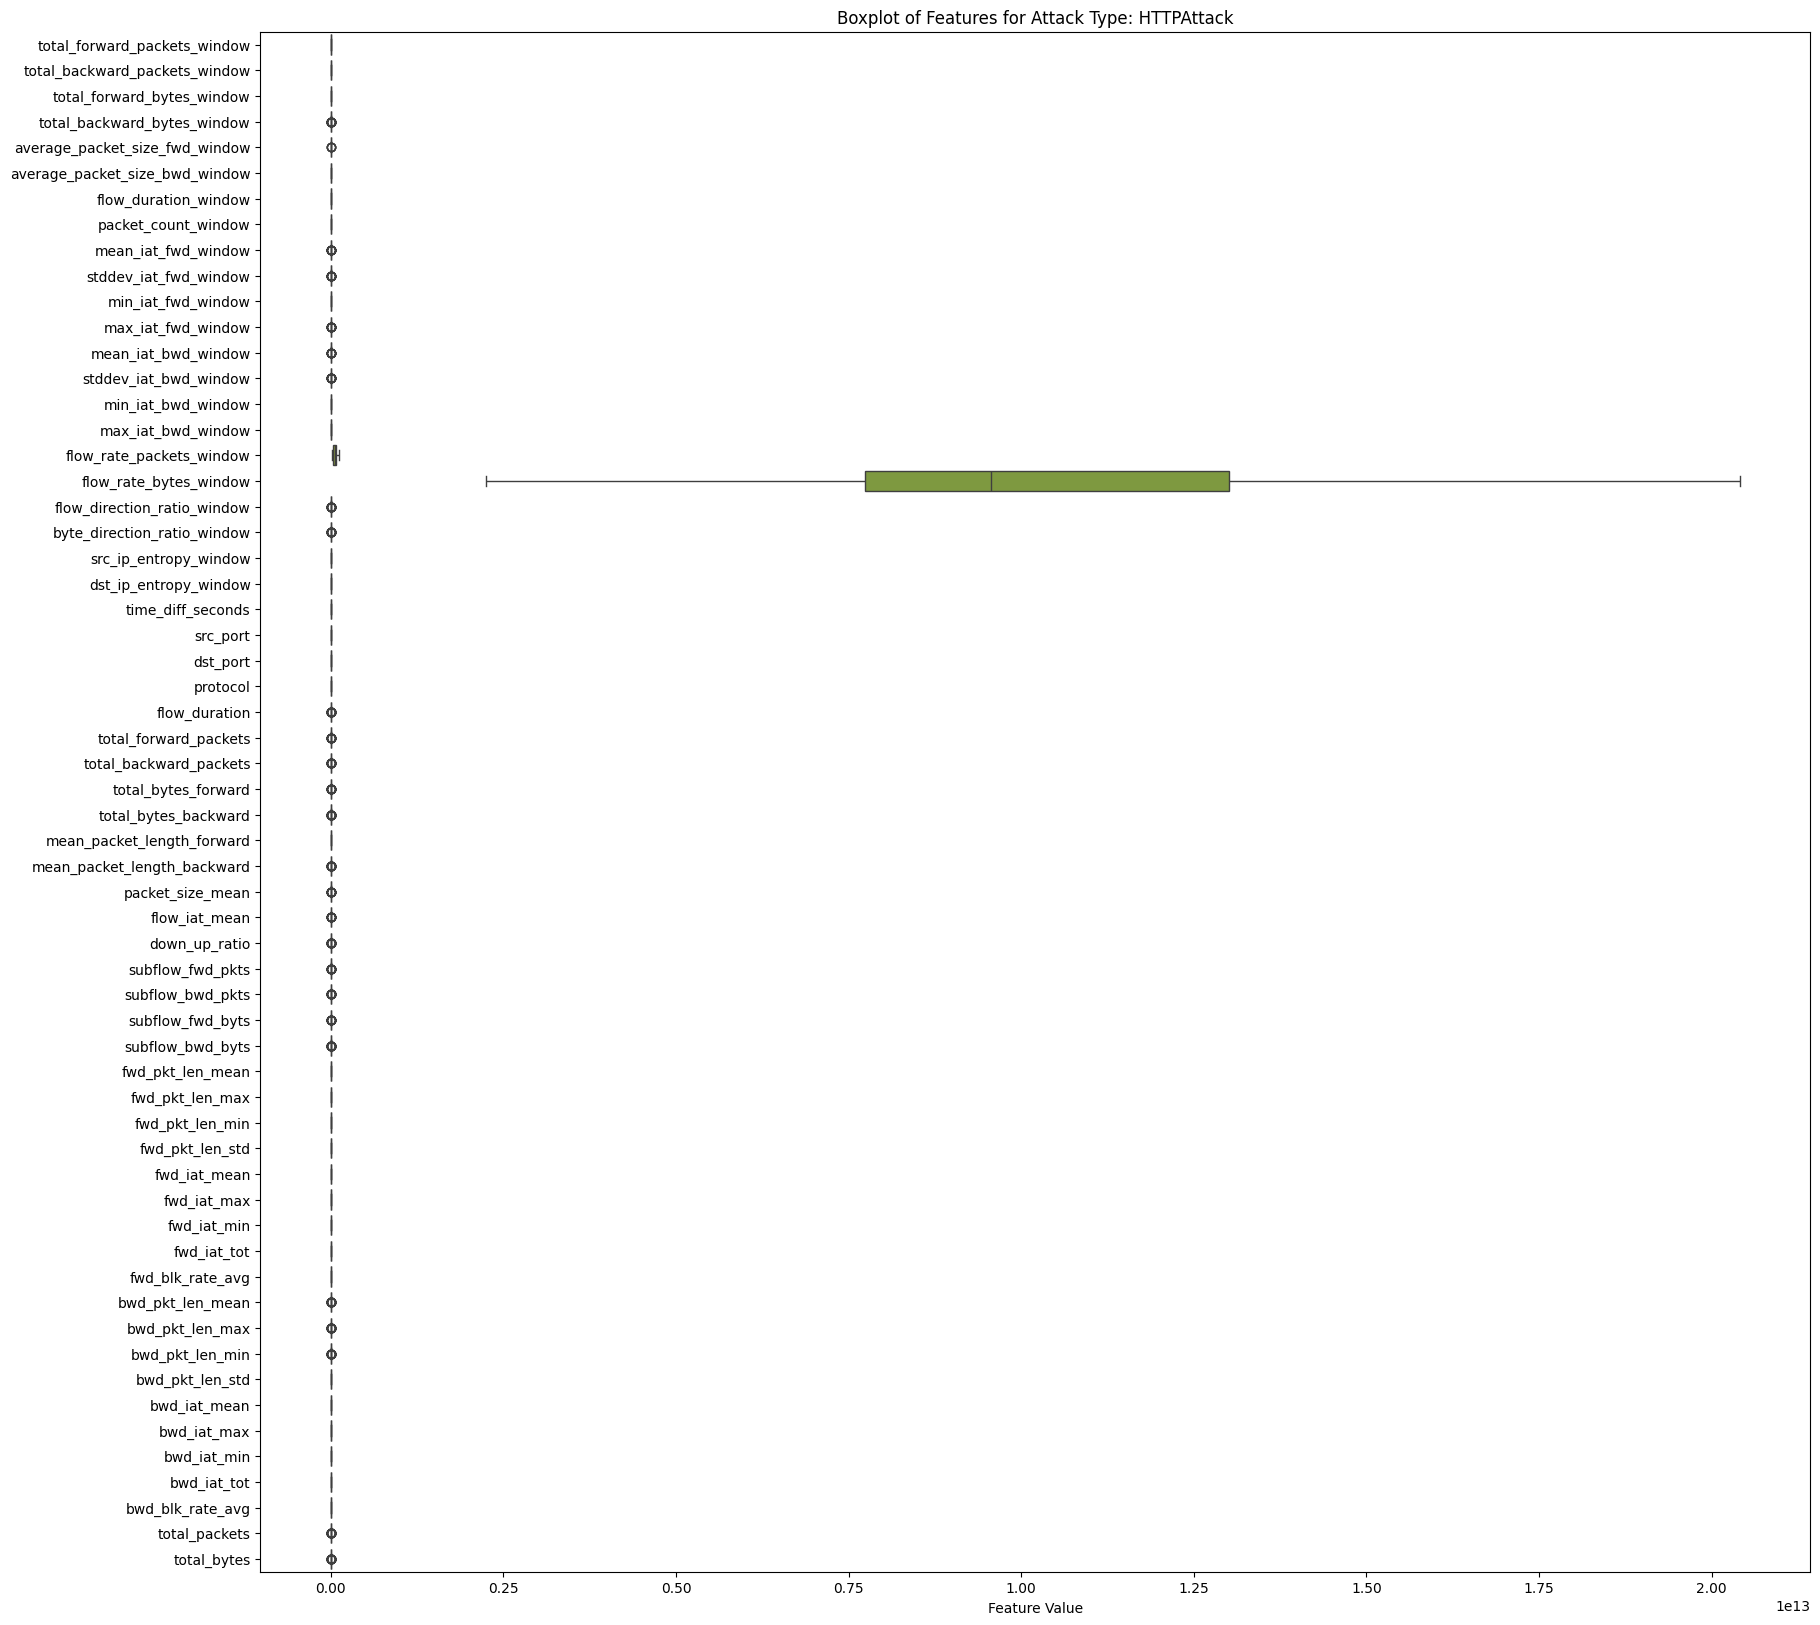

In [ ]:
for attack_type in aggregated_data['Label'].unique():
    attack_data = aggregated_data[aggregated_data['Label'] == attack_type]

    plt.figure(figsize=(20, 20))

    sns.boxplot(data = attack_data.drop(columns = ['Label']), orient = 'h')

    plt.title(f'Boxplot of Features for Attack Type: {attack_type}')
    plt.xlabel('Feature Value')

    plt.show()

In [ ]:
aggregated_data.groupby('Label').first()

,start_time,end_time_x,total_forward_packets_window,total_backward_packets_window,total_forward_bytes_window,total_backward_bytes_window,average_packet_size_fwd_window,average_packet_size_bwd_window,flow_duration_window,packet_count_window,...,bwd_pkt_len_min,bwd_pkt_len_std,bwd_iat_mean,bwd_iat_max,bwd_iat_min,bwd_iat_tot,bwd_blk_rate_avg,end_time_y,total_packets,total_bytes
Label,,,,,,,,,,,,,,,,,,,,,
Benign,2024-08-13 08:01:00,2024-08-13 08:01:05,42,9,6232,671,134.525210,8.519608,208424228,17,...,0,66.085113,0.0,0,0,0,0.0,2024-08-13 08:01:00,1,121
HTTPAttack,2024-08-13 13:59:00,2024-08-13 13:59:05,133,59,8922,3666,66.052910,48.793651,453916192,63,...,60,0.000000,0.0,0,0,0,0.0,2024-08-13 13:59:00,3,168
TCPAttack,2024-08-13 09:56:00,2024-08-13 09:56:05,98,23,14371,1583,97.714815,30.751852,563678648,30,...,60,0.000000,0.0,0,0,0,0.0,2024-08-13 09:56:00,3,168
UDPAttack,2024-08-13 11:58:00,2024-08-13 11:58:05,72,0,3972,0,55.166667,0.000000,0,72,...,0,0.000000,0.0,0,0,0,0.0,2024-08-13 11:58:00,1,42
XMasAttack,2024-08-13 08:00:00,2024-08-13 08:00:05,261,158,28218,11769,64.239935,56.293254,1370937322,126,...,60,NaN,0.0,0,0,0,0.0,2024-08-13 08:00:00,2,114


In [ ]:
# Data Preprocessing
# Dropping one unique value columns
num_unique = aggregated_data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
aggregated_data = aggregated_data[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['time_diff', 'time_diff_seconds'], dtype='object')

In [ ]:
aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23986 entries, 0 to 23985
Data columns (total 65 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   start_time                      23986 non-null  datetime64[ns]
 1   end_time_x                      23986 non-null  datetime64[ns]
 2   total_forward_packets_window    23986 non-null  int64         
 3   total_backward_packets_window   23986 non-null  int64         
 4   total_forward_bytes_window      23986 non-null  int64         
 5   total_backward_bytes_window     23986 non-null  int64         
 6   average_packet_size_fwd_window  23986 non-null  float64       
 7   average_packet_size_bwd_window  23986 non-null  float64       
 8   flow_duration_window            23986 non-null  int64         
 9   packet_count_window             23986 non-null  int64         
 10  mean_iat_fwd_window             23986 non-null  float64       
 11  st

In [ ]:
drop_columns = [
    "start_time", "end_time_x", "src_ip", "dst_ip", "end_time_y"
   ]
aggregated_data.drop(columns=drop_columns, inplace=True, errors='ignore')

In [ ]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = aggregated_data.drop('Label', axis = 1)
attacks = aggregated_data['Label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
# Identifying missing values
missing_val = aggregated_data.isna().sum()
print(missing_val.loc[missing_val > 0])

fwd_pkt_len_std    10176
bwd_pkt_len_std    10176
dtype: int64


In [ ]:
# selecting numeric attributes columns from aggregated_data
num_col = list(aggregated_data.select_dtypes(include='number').columns)
print(num_col)

['total_forward_packets_window', 'total_backward_packets_window', 'total_forward_bytes_window', 'total_backward_bytes_window', 'average_packet_size_fwd_window', 'average_packet_size_bwd_window', 'flow_duration_window', 'packet_count_window', 'mean_iat_fwd_window', 'stddev_iat_fwd_window', 'min_iat_fwd_window', 'max_iat_fwd_window', 'mean_iat_bwd_window', 'stddev_iat_bwd_window', 'min_iat_bwd_window', 'max_iat_bwd_window', 'flow_rate_packets_window', 'flow_rate_bytes_window', 'flow_direction_ratio_window', 'byte_direction_ratio_window', 'src_ip_entropy_window', 'dst_ip_entropy_window', 'src_port', 'dst_port', 'protocol', 'flow_duration', 'total_forward_packets', 'total_backward_packets', 'total_bytes_forward', 'total_bytes_backward', 'mean_packet_length_forward', 'mean_packet_length_backward', 'packet_size_mean', 'flow_iat_mean', 'down_up_ratio', 'subflow_fwd_pkts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_bwd_byts', 'fwd_pkt_len_mean', 'fwd_pkt_len_max', 'fwd_pkt_len_min', 'fwd

In [ ]:
# Checking for infinity or NaN values and replacing them with the median value of the column
aggregated_data.replace([np.inf, -np.inf], np.nan, inplace=True)
for col in num_col:
    if aggregated_data[col].isnull().sum() > 0:
        median_value = aggregated_data[col].median()
        aggregated_data[col] = aggregated_data[col].fillna(median_value)  # Direct assignment to avoid warning

In [ ]:
# Identifying missing values
missing_val = aggregated_data.isna().sum()
print(missing_val.loc[missing_val > 0])

Series([], dtype: int64)


In [ ]:
# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = aggregated_data.drop('Label', axis = 1)
attacks = aggregated_data['Label']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
from sklearn.decomposition import IncrementalPCA

size = len(features.columns) // 2
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
    ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

information retained: 99.84%


In [ ]:
# Exploring Explained Variance
print(ipca.explained_variance_ratio_)

[0.24839171 0.14720143 0.10802658 0.0939756  0.07876512 0.05884351
 0.04937145 0.03761748 0.02904145 0.02626531 0.01847438 0.0155252
 0.01451712 0.01016783 0.00947856 0.00879759 0.00820575 0.00726246
 0.006689   0.00584895 0.00449371 0.00395828 0.00194936 0.00183469
 0.00127126 0.00081521 0.00075946 0.00046845 0.00037803]


In [ ]:
# Exploring our PCA Data
expl_var = ipca.explained_variance_ratio_
df_expl_var = pd.DataFrame(
    data=zip(range(1, len(expl_var) + 1), expl_var, expl_var.cumsum()),
    columns=['IPCA', 'Explained Variance (%)', 'Total Explained Variance (%)']
    ).set_index('IPCA').mul(100).round(1)
print(df_expl_var)

      Explained Variance (%)  Total Explained Variance (%)
IPCA                                                      
1                       24.8                          24.8
2                       14.7                          39.6
3                       10.8                          50.4
4                        9.4                          59.8
5                        7.9                          67.6
6                        5.9                          73.5
7                        4.9                          78.5
8                        3.8                          82.2
9                        2.9                          85.1
10                       2.6                          87.7
11                       1.8                          89.6
12                       1.6                          91.1
13                       1.5                          92.6
14                       1.0                          93.6
15                       0.9                          94

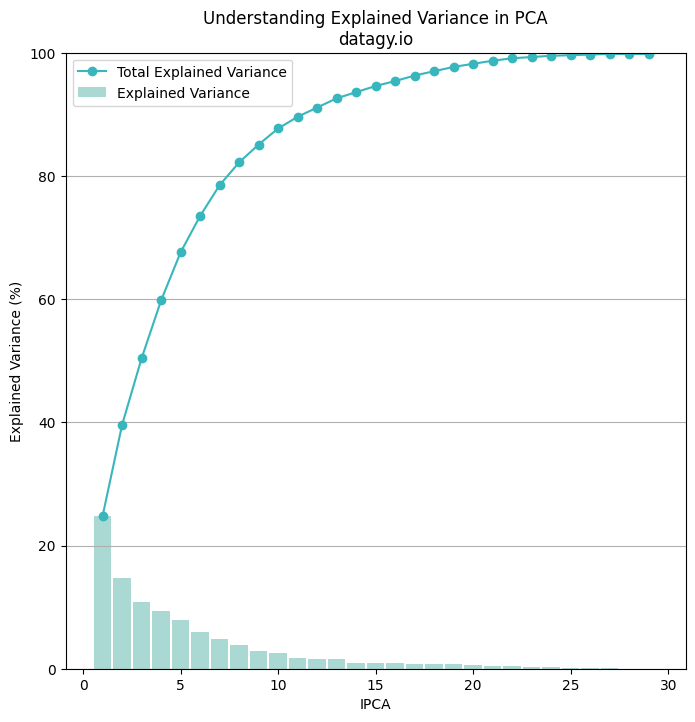

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x=df_expl_var.index, height=df_expl_var['Explained Variance (%)'], label='Explained Variance', width=0.9, color='#AAD8D3')
ax.plot(df_expl_var['Total Explained Variance (%)'], label='Total Explained Variance', marker='o', c='#37B6BD')

plt.ylim(0, 100)
plt.ylabel('Explained Variance (%)')
plt.xlabel('IPCA')
plt.grid(True, axis='y')
plt.title('Understanding Explained Variance in PCA\ndatagy.io')
plt.legend()

In [ ]:
transformed_features = ipca.transform(scaled_features)
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Label'] = attacks.values

In [ ]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,Label
0,0.860832,-0.403348,-5.338879,7.124293,4.507339,-1.599375,1.959340,-0.444811,-0.280912,0.027845,...,2.126295,-0.806743,-0.521830,0.465137,-1.187619,1.400165,-0.075529,-1.142147,-0.375695,XMasAttack
1,0.887492,-0.009400,-1.510635,4.408847,2.433052,-2.604349,-0.625242,-0.416724,2.701512,-4.174293,...,-1.040351,0.823571,0.773136,-0.906462,-0.475563,0.325874,0.078713,-0.751474,-1.088961,XMasAttack
2,0.887492,-0.009400,-1.510635,4.408847,2.433052,-2.604349,-0.625242,-0.416724,2.701512,-4.174293,...,-1.040351,0.823571,0.773136,-0.906462,-0.475563,0.325874,0.078713,-0.751474,-1.088961,XMasAttack
3,0.887492,-0.009400,-1.510635,4.408847,2.433052,-2.604349,-0.625242,-0.416724,2.701512,-4.174293,...,-1.040351,0.823571,0.773136,-0.906462,-0.475563,0.325874,0.078713,-0.751474,-1.088961,XMasAttack
4,0.887492,-0.009400,-1.510635,4.408847,2.433052,-2.604349,-0.625242,-0.416724,2.701512,-4.174293,...,-1.040351,0.823571,0.773136,-0.906462,-0.475563,0.325874,0.078713,-0.751474,-1.088961,XMasAttack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23981,-0.558367,-0.285939,-1.541895,-1.219523,-2.287734,-0.502753,-3.670037,-1.044857,1.065526,-1.730508,...,0.707923,-0.494067,-0.598784,0.008602,-0.168580,-0.121226,-0.002651,-0.093139,-0.011477,Benign
23982,-0.558367,-0.285939,-1.541895,-1.219523,-2.287734,-0.502753,-3.670037,-1.044857,1.065526,-1.730508,...,0.707923,-0.494067,-0.598784,0.008602,-0.168580,-0.121226,-0.002651,-0.093139,-0.011477,Benign
23983,-0.558367,-0.285939,-1.541895,-1.219523,-2.287734,-0.502753,-3.670037,-1.044857,1.065526,-1.730508,...,0.707923,-0.494067,-0.598784,0.008602,-0.168580,-0.121226,-0.002651,-0.093139,-0.011477,Benign
23984,-0.558367,-0.285939,-1.541895,-1.219523,-2.287734,-0.502753,-3.670037,-1.044857,1.065526,-1.730508,...,0.707923,-0.494067,-0.598784,0.008602,-0.168580,-0.121226,-0.002651,-0.093139,-0.011477,Benign


In [ ]:
# Machine Learning  Models
from sklearn.model_selection import cross_val_score

In [ ]:
new_data['BinLabel'] = aggregated_data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [ ]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,Label,BinLabel
0,0.860832,-0.403348,-5.338879,7.124293,4.507339,-1.599375,1.959340,-0.444811,-0.280912,0.027845,...,-0.806743,-0.521830,0.465137,-1.187619,1.400165,-0.075529,-1.142147,-0.375695,XMasAttack,1
1,0.887492,-0.009400,-1.510635,4.408847,2.433052,-2.604349,-0.625242,-0.416724,2.701512,-4.174293,...,0.823571,0.773136,-0.906462,-0.475563,0.325874,0.078713,-0.751474,-1.088961,XMasAttack,1
2,0.887492,-0.009400,-1.510635,4.408847,2.433052,-2.604349,-0.625242,-0.416724,2.701512,-4.174293,...,0.823571,0.773136,-0.906462,-0.475563,0.325874,0.078713,-0.751474,-1.088961,XMasAttack,1
3,0.887492,-0.009400,-1.510635,4.408847,2.433052,-2.604349,-0.625242,-0.416724,2.701512,-4.174293,...,0.823571,0.773136,-0.906462,-0.475563,0.325874,0.078713,-0.751474,-1.088961,XMasAttack,1
4,0.887492,-0.009400,-1.510635,4.408847,2.433052,-2.604349,-0.625242,-0.416724,2.701512,-4.174293,...,0.823571,0.773136,-0.906462,-0.475563,0.325874,0.078713,-0.751474,-1.088961,XMasAttack,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23981,-0.558367,-0.285939,-1.541895,-1.219523,-2.287734,-0.502753,-3.670037,-1.044857,1.065526,-1.730508,...,-0.494067,-0.598784,0.008602,-0.168580,-0.121226,-0.002651,-0.093139,-0.011477,Benign,0
23982,-0.558367,-0.285939,-1.541895,-1.219523,-2.287734,-0.502753,-3.670037,-1.044857,1.065526,-1.730508,...,-0.494067,-0.598784,0.008602,-0.168580,-0.121226,-0.002651,-0.093139,-0.011477,Benign,0
23983,-0.558367,-0.285939,-1.541895,-1.219523,-2.287734,-0.502753,-3.670037,-1.044857,1.065526,-1.730508,...,-0.494067,-0.598784,0.008602,-0.168580,-0.121226,-0.002651,-0.093139,-0.011477,Benign,0
23984,-0.558367,-0.285939,-1.541895,-1.219523,-2.287734,-0.502753,-3.670037,-1.044857,1.065526,-1.730508,...,-0.494067,-0.598784,0.008602,-0.168580,-0.121226,-0.002651,-0.093139,-0.011477,Benign,0


In [ ]:
from sklearn.model_selection import train_test_split

X_bin_class = new_data.drop(columns=['Label','BinLabel'], axis = 1)
y_bin_class = new_data['BinLabel']

X_train_bin_class, X_test_bin_class, y_train_bin_class, y_test_bin_class = train_test_split(X_bin_class, y_bin_class, test_size = 0.25, random_state = 0)


In [ ]:
# Logistic Regression (Binary Classification)
from sklearn.linear_model import LogisticRegression

lr1 = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga')
lr1.fit(X_train_bin_class, y_train_bin_class)

cv_lr1 = cross_val_score(lr1, X_train_bin_class, y_train_bin_class, cv = 5)
print('Logistic regression Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lr1)))
print(f'\nMean cross-validation score: {cv_lr1.mean():.2f}')

Logistic regression Model 1

Cross-validation scores: 1.0, 1.0, 0.999722067815453, 0.9983324068927182, 0.9991659716430359

Mean cross-validation score: 1.00


In [ ]:
print('Logistic Regression Model 1 coefficients:')
print(*lr1.coef_, sep = ', ')
print('\nLogistic Regression Model 1 intercept:', *lr1.intercept_)


Logistic Regression Model 1 coefficients:
[-0.00761975 -0.04736953 -0.61167395  0.390873    0.11071356 -0.40678931
  0.11687347  0.04844245  0.61233606 -1.0362907  -0.66093946 -0.15424222
 -0.81019499 -0.28376469 -0.08946748 -0.1194933  -0.10713218 -0.31330597
 -0.10292174 -0.11146321 -0.25796812 -0.03767952 -0.77611513 -0.87658779
 -0.10025548  0.09598515  0.07537058 -0.10379345 -0.21197719]

Logistic Regression Model 1 intercept: -6.9624134355391245


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
y_pred = lr1.predict(X_test_bin_class)

In [ ]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5798    5]
 [   0  194]]


In [ ]:
# Precision, Recall, and F1-Score
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       0.97      1.00      0.99       194

    accuracy                           1.00      5997
   macro avg       0.99      1.00      0.99      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
new_data.to_csv('/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/aggregated_data.csv', index=False)

In [ ]:
import joblib
joblib.dump(lr1,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/logisticregression_model1.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# save the scaler and pca
import joblib
joblib.dump(scaler,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/scaler.pkl')
joblib.dump(ipca,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/pca.pkl')

['/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/pca.pkl']

In [ ]:
lr2 = LogisticRegression(max_iter = 15000, solver = 'sag', C = 100, random_state = 0)
lr2.fit(X_train_bin_class, y_train_bin_class)

cv_lr2 = cross_val_score(lr2, X_train_bin_class, y_train_bin_class, cv = 5)
print('Logistic regression Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lr2)))
print(f'\nMean cross-validation score: {cv_lr2.mean():.2f}')

Logistic regression Model 2

Cross-validation scores: 1.0, 1.0, 0.999722067815453, 0.9983324068927182, 0.9991659716430359

Mean cross-validation score: 1.00


In [ ]:
print('Logistic Regression Model 2 coefficients:')
print(*lr2.coef_, sep = ', ')
print('\nLogistic Regression Model 2 intercept:', *lr2.intercept_)

Logistic Regression Model 2 coefficients:
[-0.03287193 -0.09036688 -0.84518631  0.35180069  0.15866786 -0.69867328
  0.33173545  0.10791104  0.74789319 -1.12533072 -0.5649541  -0.13847299
 -0.72357618 -0.20420101 -0.15838068  0.07534578 -0.13811963 -0.46111572
 -0.07748285 -0.14226876 -0.5752293  -0.15616689 -1.37522365 -1.54891975
 -0.20883775  0.1825674   0.17730188 -0.38988564 -0.43840905]

Logistic Regression Model 2 intercept: -8.673772795226231


In [ ]:
y_pred = lr2.predict(X_test_bin_class)

In [ ]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5798    5]
 [   0  194]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       0.97      1.00      0.99       194

    accuracy                           1.00      5997
   macro avg       0.99      1.00      0.99      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(lr2,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/logisticregression_model2.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Deep Learning model
# Build the binary classification model
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout

model = Sequential([
    Input(shape=(X_train_bin_class.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),  # Dropout layer for regularization
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_bin_class, y_train_bin_class, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9501 - loss: 0.1619 - val_accuracy: 0.9989 - val_loss: 0.0054
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9995 - loss: 0.0057 - val_accuracy: 0.9992 - val_loss: 0.0041
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 0.9992 - val_loss: 0.0025
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9999 - loss: 8.9794e-04 - val_accuracy: 0.9997 - val_loss: 4.9105e-04
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 5.7862e-04
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 7.4842e-04 - 

In [ ]:
loss, accuracy = model.evaluate(X_test_bin_class, y_test_bin_class)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9997 - loss: 0.0032
Test Loss: 0.0016292071668431163, Test Accuracy: 0.9998332262039185


In [ ]:
y_pred = (model.predict(X_test_bin_class) > 0.5).astype(int)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5802    1]
 [   0  194]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       0.99      1.00      1.00       194

    accuracy                           1.00      5997
   macro avg       1.00      1.00      1.00      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(model,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/deeplearning_model.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Support Vector Machine (Binary Classification)
from sklearn.svm import SVC

svm1 = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm1.fit(X_train_bin_class, y_train_bin_class)

cv_svm1 = cross_val_score(svm1, X_train_bin_class, y_train_bin_class, cv = 5)
print('Support Vector Machine Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_svm1)))
print(f'\nMean cross-validation score: {cv_svm1.mean():.2f}')

Support Vector Machine Model 1

Cross-validation scores: 1.0, 1.0, 1.0, 0.999722067815453, 0.9997219905476786

Mean cross-validation score: 1.00


In [ ]:
y_pred_svm = svm1.predict(X_test_bin_class)

In [ ]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_svm)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5800    3]
 [   0  194]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_svm))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       0.98      1.00      0.99       194

    accuracy                           1.00      5997
   macro avg       0.99      1.00      1.00      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(svm1,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/svm_model1.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
svm2 = SVC(kernel = 'rbf', C = 1, gamma = 0.1, random_state = 0, probability = True)
svm2.fit(X_train_bin_class, y_train_bin_class)

cv_svm2 = cross_val_score(svm2, X_train_bin_class, y_train_bin_class, cv = 5)
print('Support Vector Machine Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_svm2)))
print(f'\nMean cross-validation score: {cv_svm2.mean():.2f}')

Support Vector Machine Model 2

Cross-validation scores: 1.0, 0.9994441356309061, 0.9994441356309061, 0.999722067815453, 0.9991659716430359

Mean cross-validation score: 1.00


In [ ]:
y_pred_svm1 = svm2.predict(X_test_bin_class)

In [ ]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_svm1)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5803    0]
 [   1  193]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_svm1))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       1.00      0.99      1.00       194

    accuracy                           1.00      5997
   macro avg       1.00      1.00      1.00      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
print('SVM Model 1 intercept:', *svm1.intercept_)
print('SVM Model 2 intercept:', *svm2.intercept_)

SVM Model 1 intercept: -1.1723233907979052
SVM Model 2 intercept: -0.5851815229160489


In [ ]:
joblib.dump(svm2,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/svm_model2.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train_bin_class, y_train_bin_class)

# Cross-validation
cv_dt = cross_val_score(dt, X_train_bin_class, y_train_bin_class, cv=5)
print('Decision Tree Classifier')
print(f'Cross-validation scores: {", ".join(map(str, cv_dt))}')
print(f'Mean cross-validation score: {cv_dt.mean():.2f}')

Decision Tree Classifier
Cross-validation scores: 0.999722067815453, 0.999722067815453, 1.0, 0.9991662034463591, 0.9991659716430359
Mean cross-validation score: 1.00


In [ ]:
y_pred_dt = dt.predict(X_test_bin_class)

In [ ]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_dt)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5800    3]
 [   0  194]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_dt))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       0.98      1.00      0.99       194

    accuracy                           1.00      5997
   macro avg       0.99      1.00      1.00      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(dt,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/decision_tree.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_bin_class, y_train_bin_class)

# Cross-validation
cv_rf = cross_val_score(rf, X_train_bin_class, y_train_bin_class, cv=5)
print('Random Forest Classifier')
print(f'Cross-validation scores: {", ".join(map(str, cv_rf))}')
print(f'Mean cross-validation score: {cv_rf.mean():.2f}')

Random Forest Classifier
Cross-validation scores: 1.0, 1.0, 1.0, 1.0, 1.0
Mean cross-validation score: 1.00


In [ ]:
y_pred_rf = rf.predict(X_test_bin_class)

In [ ]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_rf)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5802    1]
 [   0  194]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       0.99      1.00      1.00       194

    accuracy                           1.00      5997
   macro avg       1.00      1.00      1.00      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(rf,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/random_forest.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_bin_class, y_train_bin_class)

cv_knn = cross_val_score(knn, X_train_bin_class, y_train_bin_class, cv=5)
print('K-Nearest Neighbors Classifier')
print(f'Cross-validation scores: {", ".join(map(str, cv_knn))}')
print(f'Mean cross-validation score: {cv_knn.mean():.2f}')

K-Nearest Neighbors Classifier
Cross-validation scores: 0.9994441356309061, 1.0, 1.0, 0.999722067815453, 0.9991659716430359
Mean cross-validation score: 1.00


In [ ]:
y_pred_knn = knn.predict(X_test_bin_class)

In [ ]:
conf_matrix = confusion_matrix(y_test_bin_class, y_pred_knn)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5800    3]
 [   0  194]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test_bin_class, y_pred_knn))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       0.98      1.00      0.99       194

    accuracy                           1.00      5997
   macro avg       0.99      1.00      1.00      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(knn,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/binary_models/knearest_neighbor.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Multi-Classification

In [ ]:
features = new_data.drop(columns=['Label', 'BinLabel'], axis = 1)
labels = new_data['Label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
num_classes = len(y_train.unique())

In [ ]:
multi_model = Sequential()
multi_model.add(Input(shape=(X_train.shape[1],)))
multi_model.add(Dense(128, activation='relu'))
multi_model.add(Dropout(0.5))  # Dropout to prevent overfitting
multi_model.add(Dense(64, activation='relu'))
multi_model.add(Dropout(0.5))  # Dropout to prevent overfitting

multi_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
multi_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
multi_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 128)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,421 (48.52 KB)

 Trainable params: 12,421 (48.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the string labels to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the integer labels
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

In [ ]:
history = multi_model.fit(X_train, y_train_cat, epochs=50, batch_size=16, validation_data=(X_test, y_test_cat))

Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9441 - loss: 0.2192 - val_accuracy: 0.9927 - val_loss: 0.0155
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9898 - loss: 0.0246 - val_accuracy: 0.9897 - val_loss: 0.0143
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9900 - loss: 0.0191 - val_accuracy: 0.9928 - val_loss: 0.0137
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9919 - loss: 0.0168 - val_accuracy: 0.9928 - val_loss: 0.0138
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9915 - loss: 0.0170 - val_accuracy: 0.9928 - val_loss: 0.0126
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9928 - loss: 0.0137 - val_accuracy: 0.9928 - val_loss: 0.0128
Epoch 7/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9922 - loss: 0.0137 - val_accuracy: 0.9928 - val_loss: 0.0139
Epoch 8/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9933 - loss: 0.0129 - 

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9942 - loss: 0.0160
Test Loss: 0.012172055430710316, Test Accuracy: 0.9951642751693726


In [ ]:
y_pred_prob = model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[5802    0    0    0    1]
 [   0   17   23    0    0]
 [   0    5   54    0    0]
 [   0    0    0   63    0]
 [   0    0    0    0   32]]


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=1))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5803
           1       0.77      0.42      0.55        40
           2       0.70      0.92      0.79        59
           3       1.00      1.00      1.00        63
           4       0.97      1.00      0.98        32

    accuracy                           1.00      5997
   macro avg       0.89      0.87      0.87      5997
weighted avg       1.00      1.00      0.99      5997



In [ ]:
joblib.dump(multi_model,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/multi_class_models/multiclass_deeplearning.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 10, max_depth = 6, max_features = None, random_state = 0)
rf1.fit(X_train, y_train)

cv_rf1 = cross_val_score(rf1, X_train, y_train, cv = 5)
print('Random Forest Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf1)))
print(f'\nMean cross-validation score: {cv_rf1.mean():.2f}')

Random Forest Model 1

Cross-validation scores: 0.9961089494163424, 0.9961089494163424, 0.9972206781545303, 0.9974986103390773, 0.9958298582151793

Mean cross-validation score: 1.00


In [ ]:
y_pred_rfc = rf1.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rfc)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5800    1    2    0    0]
 [   0   24   16    0    0]
 [   0    1   58    0    0]
 [   1    0    0   62    0]
 [   0    0    0    0   32]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_rfc))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5803
  HTTPAttack       0.92      0.60      0.73        40
   TCPAttack       0.76      0.98      0.86        59
   UDPAttack       1.00      0.98      0.99        63
  XMasAttack       1.00      1.00      1.00        32

    accuracy                           1.00      5997
   macro avg       0.94      0.91      0.92      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(rf1,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/multi_class_models/rf1_model.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
rf2 = RandomForestClassifier(n_estimators = 15, max_depth = 8, max_features = 20, random_state = 0)
rf2.fit(X_train, y_train)

cv_rf2 = cross_val_score(rf2, X_train, y_train, cv = 5)
print('Random Forest Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf2)))
print(f'\nMean cross-validation score: {cv_rf2.mean():.2f}')

Random Forest Model 2

Cross-validation scores: 0.9983324068927182, 0.9983324068927182, 0.9977765425236242, 0.9974986103390773, 0.9974979149291076

Mean cross-validation score: 1.00


In [ ]:
y_pred_rfc1 = rf2.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rfc1)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5803    0    0    0    0]
 [   0   28   12    0    0]
 [   0    2   57    0    0]
 [   1    0    0   62    0]
 [   0    0    0    0   32]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_rfc1))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5803
  HTTPAttack       0.93      0.70      0.80        40
   TCPAttack       0.83      0.97      0.89        59
   UDPAttack       1.00      0.98      0.99        63
  XMasAttack       1.00      1.00      1.00        32

    accuracy                           1.00      5997
   macro avg       0.95      0.93      0.94      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(rf2,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/multi_class_models/rf2_model.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dt1 = DecisionTreeClassifier(max_depth = 6)
dt1.fit(X_train, y_train)

cv_dt1 = cross_val_score(dt1, X_train, y_train, cv = 5)
print('Decision Tree Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt1)))
print(f'\nMean cross-validation score: {cv_dt1.mean():.2f}')

Decision Tree Model 1

Cross-validation scores: 0.9947192884936076, 0.9927737632017788, 0.9947192884936076, 0.9952751528627015, 0.994161801501251

Mean cross-validation score: 0.99


In [ ]:
y_pred_dt1 = dt1.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_dt1)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5802    0    1    0    0]
 [   0   28   12    0    0]
 [   0    7   52    0    0]
 [   1    0    0   62    0]
 [   2    0    0    0   30]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_dt1))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5803
  HTTPAttack       0.80      0.70      0.75        40
   TCPAttack       0.80      0.88      0.84        59
   UDPAttack       1.00      0.98      0.99        63
  XMasAttack       1.00      0.94      0.97        32

    accuracy                           1.00      5997
   macro avg       0.92      0.90      0.91      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(dt1,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/multi_class_models/dt1_model.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
dt2 = DecisionTreeClassifier(max_depth = 8)
dt2.fit(X_train, y_train)

cv_dt2 = cross_val_score(dt2, X_train, y_train, cv = 5)
print('Decision Tree Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt2)))
print(f'\nMean cross-validation score: {cv_dt2.mean():.2f}')

Decision Tree Model 2

Cross-validation scores: 0.9961089494163424, 0.9961089494163424, 0.9963868816008894, 0.9963868816008894, 0.9972199054767862

Mean cross-validation score: 1.00


In [ ]:
y_pred_dt2 = dt2.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_dt2)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5802    0    1    0    0]
 [   0   32    8    0    0]
 [   0    5   54    0    0]
 [   1    0    0   62    0]
 [   0    0    0    0   32]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_dt2))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5803
  HTTPAttack       0.86      0.80      0.83        40
   TCPAttack       0.86      0.92      0.89        59
   UDPAttack       1.00      0.98      0.99        63
  XMasAttack       1.00      1.00      1.00        32

    accuracy                           1.00      5997
   macro avg       0.94      0.94      0.94      5997
weighted avg       1.00      1.00      1.00      5997



In [ ]:
joblib.dump(dt2,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/multi_class_models/dt2_model.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# K Nearest Neighbours
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors = 16)
knn1.fit(X_train, y_train)

cv_knn1 = cross_val_score(knn1, X_train, y_train, cv = 5)
print('K Nearest Neighbors Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn1)))
print(f'\nMean cross-validation score: {cv_knn1.mean():.2f}')

K Nearest Neighbors Model 1

Cross-validation scores: 0.9902723735408561, 0.9927737632017788, 0.9927737632017788, 0.9913841022790439, 0.9924937447873228

Mean cross-validation score: 0.99


In [ ]:
y_pred_knn1 = knn1.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_knn1)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5800    0    0    0    3]
 [   0   19   21    0    0]
 [   0   12   47    0    0]
 [   0    0    0   63    0]
 [   0    0    1    0   31]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn1))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5803
  HTTPAttack       0.61      0.47      0.54        40
   TCPAttack       0.68      0.80      0.73        59
   UDPAttack       1.00      1.00      1.00        63
  XMasAttack       0.91      0.97      0.94        32

    accuracy                           0.99      5997
   macro avg       0.84      0.85      0.84      5997
weighted avg       0.99      0.99      0.99      5997



In [ ]:
joblib.dump(knn1,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/multi_class_models/knn1_model.pkl')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
knn2 = KNeighborsClassifier(n_neighbors = 8)
knn2.fit(X_train, y_train)

cv_knn2 = cross_val_score(knn2, X_train, y_train, cv = 5)
print('K Nearest Neighbors Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn2)))
print(f'\nMean cross-validation score: {cv_knn2.mean():.2f}')

K Nearest Neighbors Model 1

Cross-validation scores: 0.9933296275708727, 0.9952751528627015, 0.9927737632017788, 0.9944413563090606, 0.9933277731442869

Mean cross-validation score: 0.99


In [ ]:
y_pred_knn2 = knn2.predict(X_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_knn2)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[5800    0    0    0    3]
 [   2   20   18    0    0]
 [   1   10   48    0    0]
 [   0    0    0   63    0]
 [   0    0    0    0   32]]


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_knn2))

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5803
  HTTPAttack       0.67      0.50      0.57        40
   TCPAttack       0.73      0.81      0.77        59
   UDPAttack       1.00      1.00      1.00        63
  XMasAttack       0.91      1.00      0.96        32

    accuracy                           0.99      5997
   macro avg       0.86      0.86      0.86      5997
weighted avg       0.99      0.99      0.99      5997



In [ ]:
joblib.dump(knn2,'/content/drive/MyDrive/Labelled_Multiclass_Dataset/multi_class_models/knn2_model.pkl')
print("Model saved successfully.")

Model saved successfully.
